# Product and Inventory Analysis

    By Jordan Grose, Shiqi Sun, Mark Mao, Kangjing Shi, Man Shi
---

**Project Description:**  
Our goal is to establish a performance metric for each product based on the historical sales data available. Using this metric, we will create predictions for whether a given product will be sold. We will harness historical data to build a prediction model that assigns a probability of sale for each product in the future. We will study the correlations between product sales and other factors, such as sale volume, cost, and marketing type to construct our performance metric and prediction model.

**Data:**  
[Link to original dataset.](https://www.kaggle.com/flenderson/sales-analysis)  

Here is an existing notebook that we have based some of our analysis on: [mdneuzerling's analysis](https://htmlpreview.github.io/?https://github.com/mdneuzerling/flenderson_sales/blob/master/exploration.html)  

We will be looking at a SKU/inventory dataset from Kaggle that was uploaded by an unknown retail company. The dataset consists of two parts, historical and active SKUs. The historical dataset contains historical sales data for SKUs. The active dataset contains SKUs that are in the active inventory. Although the dataset was uploaded to Kaggle years ago, we will treat the active data as the current inventory. Our eventual goal is to determine a probability of sale for active SKUs after analyzing the historical SKU sales data. Many of the historical SKUs are also present in the active inventory. Each row in both datasets represent a distinct SKU. Below is breakdown of all relevant variables in both datasets.  


- *SKU_number:* This is the unique identifier for each SKU.

- *SoldFlag:* Category, 1 = sold in past 6 months, 0 = Not sold in the past 6 months. When SoldFlagis zero, SoldCount always zero. SoldFlag can be Null. When it is Null, SoldCount will be NA too. Both SoldFlag and SoldCount are Null in the active dataset as these SKUs have not been sold and this is the target variable we are trying to predict.

- *SoldCount:* Count how many items were sold for this item in the last 6 months.

- *MarketingType:* Two categories of how we market the product ("D" and "S"), each type should be considered independently.

- *ReleaseNumber:* This will count the number of items that are going to be released in the future.

- *New_Release_Flag:* Any product that has had a future release (i.e., Release Number > 1). When New_Release_Flag is zero, ReleaseNumber will be zero also.

- *StrengthFactor:* Represents the performance of the items depending on ItemCount, SoldFlag and Price.

- *ReleaseYear:* When the SKU was originally released (year).

- *ItemCount:* Represents the number of items in the inventory per SKU. Many values in ItemCount are 0.

- *PriceReg:* PriceReg we assume stands for regular price of the SKU.

- *LowNetPrice:* Another price metric per SKU, we assume stands for the net price to sell SKU after expenses.

- *LowUserPrice:* Another price metric per SKU. It is worth noting that [mdneuzerling's analysis](https://htmlpreview.github.io/?https://github.com/mdneuzerling/flenderson_sales/blob/master/exploration.html) treats LowUserPrice as the primary SKU price since it has the fewest count of 0-dollar values. In general, we will follow this guideline, however, we will also look at how the other two price variables (PriceReg & LowNetPrice) vary across SKU's and SKU sales performance.

- *Class:* Specifies the ABC classification category for each SKU. This classification method is based off of ["ABC Inventory Analysis"](https://en.wikipedia.org/wiki/ABC_analysis) which sorts SKUs in a given inventory by their relative value to the entire inventory value. Using the below rubric, we have assigned a class value of A, B or C to each SKU. In general, SKUs in the A class are more valueable (price * quantity), or have a higher opportunity cost to the retailer, whereas SKUs in the C class are less valuable, or costly, to the retailer. Typically an inventory will have fewer "high value" SKUs and many "low value" SKUs. The retailer should prioritize selling Class A SKUs to maintain a healthy inventory cost and make more money through high value sales.
> - A items - Captures roughly 20% of the items in the relevant inventory and accounts for roughly 70% of the inventory value
> - B items - Captures roughly 30% of the items in the relevant inventory and accounts for roughly 25% of the inventory value
> - C items - Captures roughly 50% of the items in the relevant inventory and accounts for roughly 5% of the inventory value


## Loading the Dataset and Preprocessing

In [104]:
# confirm current directory is within GCP AI platform path: /home/jupyter/BA780
!pwd

/home/jupyter/BA780


In [105]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.cloud import storage

In [106]:
# function to get the dataset from GCP storage bucket
def download_blob(project_id, bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # project_id = "ba775-team-3a-291914"
    # bucket_name = "msba775-group"
    # source_blob_name = "df_historical_abc"
    # destination_file_name = "BA780/df_historical_abc"

    storage_client = storage.Client(project_id)

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    )

In [4]:
download_blob(project_id="ba775-team-3a-291914", bucket_name="msba775-group", 
              source_blob_name="historical_ABC.csv", 
              destination_file_name="historical_ABC")

Blob historical_ABC.csv downloaded to historical_ABC.


In [107]:
df_historical_abc_ori = pd.read_csv('historical_ABC')
df_historical_abc=df_historical_abc_ori
df_historical_abc.head()

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotalSum,RunPerc,Class
0,10814,Historical,618154,0,0,D,5,1,2219727,259.00,2002,21,14140.21,9.30,296944.41,296944.41,197475980.5,0.001504,A
1,46977,Historical,545616,0,0,S,3,1,115726,77.95,2011,29,7781.01,51.49,225649.29,522593.70,197475980.5,0.002646,A
2,73868,Historical,174356,0,0,S,0,0,300352,79.99,2004,25,7781.00,60.96,194525.00,717118.70,197475980.5,0.003631,A
3,32426,Historical,132474,0,0,D,9,1,175474,170.20,2008,48,3608.97,28.03,173230.56,890349.26,197475980.5,0.004509,A
4,54577,Historical,291246,0,0,S,0,0,431590,60.00,1997,20,7781.00,78.99,155620.00,1045969.26,197475980.5,0.005297,A


In [6]:
download_blob(project_id="ba775-team-3a-291914", bucket_name="msba775-group", 
              source_blob_name="active_ABC.csv", 
              destination_file_name="active_ABC")

Blob active_ABC.csv downloaded to active_ABC.


In [108]:
df_active_abc_ori = pd.read_csv('active_ABC')
df_active_abc=df_active_abc_ori
df_active_abc.head()

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotSum,RunPerc,Class
0,141927,Active,540670,NaN,NaN,S,3,1,1.443928e+03,298.00,2013,274,46.49,70.99,12738.26,12738.26,58985115.47,0.000216,A
1,126396,Active,610364,NaN,NaN,S,7,1,6.417150e+02,300.95,2014,202,50.05,60.97,10110.10,22848.36,58985115.47,0.000387,A
2,138926,Active,543726,NaN,NaN,S,4,1,9.508895e+03,115.00,2013,120,84.23,74.00,10107.60,32955.96,58985115.47,0.000559,A
3,103301,Active,2185992,NaN,NaN,D,0,0,1.175402e+06,189.00,2009,97,102.81,117.70,9972.57,42928.53,58985115.47,0.000728,A
4,185607,Active,315714,NaN,NaN,D,0,0,6.317052e+03,125.00,2010,200,45.52,71.23,9104.00,52032.53,58985115.47,0.000882,A


In [6]:
df_historical_abc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75996 entries, 0 to 75995
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order             75996 non-null  int64  
 1   File_Type         75996 non-null  object 
 2   SKU_number        75996 non-null  int64  
 3   SoldFlag          75996 non-null  int64  
 4   SoldCount         75996 non-null  int64  
 5   MarketingType     75996 non-null  object 
 6   ReleaseNumber     75996 non-null  int64  
 7   New_Release_Flag  75996 non-null  int64  
 8   StrengthFactor    75996 non-null  int64  
 9   PriceReg          75996 non-null  float64
 10  ReleaseYear       75996 non-null  int64  
 11  ItemCount         75996 non-null  int64  
 12  LowUserPrice      75996 non-null  float64
 13  LowNetPrice       75996 non-null  float64
 14  AddCost           75996 non-null  float64
 15  RunCumCost        75996 non-null  float64
 16  TotalSum          75996 non-null  float6

In [7]:
df_active_abc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122921 entries, 0 to 122920
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Order             122921 non-null  int64  
 1   File_Type         122921 non-null  object 
 2   SKU_number        122921 non-null  int64  
 3   SoldFlag          0 non-null       float64
 4   SoldCount         0 non-null       float64
 5   MarketingType     122921 non-null  object 
 6   ReleaseNumber     122921 non-null  int64  
 7   New_Release_Flag  122921 non-null  int64  
 8   StrengthFactor    122921 non-null  float64
 9   PriceReg          122921 non-null  float64
 10  ReleaseYear       122921 non-null  int64  
 11  ItemCount         122921 non-null  int64  
 12  LowUserPrice      122921 non-null  float64
 13  LowNetPrice       122921 non-null  float64
 14  AddCost           122921 non-null  float64
 15  RunCumCost        122921 non-null  float64
 16  TotSum            12

In [8]:
df_historical_abc.describe()

,Order,SKU_number,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotalSum,RunPerc
count,75996.000000,7.599600e+04,75996.000000,75996.000000,75996.000000,75996.000000,7.599600e+04,75996.000000,75996.000000,75996.000000,75996.000000,75996.000000,75996.000000,7.599600e+04,75996.0,75996.000000
mean,41649.886362,6.522446e+05,0.171009,0.322306,4.152534,0.789068,1.222439e+06,98.730594,2005.973341,43.843637,56.708431,47.186160,2598.504927,1.575392e+08,197475980.5,0.797764
std,25041.351458,6.862036e+05,0.376519,1.168615,3.950739,0.407973,1.540521e+06,78.712358,6.113771,37.362231,104.758351,129.814719,4342.519506,4.540662e+07,0.0,0.229935
min,2.000000,5.000100e+04,0.000000,0.000000,0.000000,0.000000,6.800000e+01,0.000000,1935.000000,0.000000,0.000000,0.000000,0.000000,2.969444e+05,197475980.5,0.001504
25%,19440.750000,1.700568e+05,0.000000,0.000000,2.000000,1.000000,2.446812e+05,49.950000,2003.000000,22.000000,20.490000,18.740000,585.900000,1.347255e+08,197475980.5,0.682237
50%,41566.500000,5.409220e+05,0.000000,0.000000,3.000000,1.000000,7.160165e+05,78.950000,2007.000000,34.000000,44.030000,36.130000,1437.370000,1.753187e+08,197475980.5,0.887797
75%,63489.500000,7.592552e+05,0.000000,0.000000,6.000000,1.000000,1.554032e+06,127.000000,2010.000000,53.000000,79.380000,56.920000,3098.272500,1.941028e+08,197475980.5,0.982919
max,85106.000000,3.959831e+06,1.000000,73.000000,99.000000,1.000000,1.666966e+07,3986.310000,2017.000000,1523.000000,14140.210000,19138.790000,296944.410000,1.974760e+08,197475980.5,1.000000


In [9]:
df_active_abc.describe()

,Order,SKU_number,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotSum,RunPerc
count,122921.000000,1.229210e+05,0.0,0.0,122921.000000,122921.000000,1.229210e+05,122921.000000,122921.000000,122921.000000,122921.000000,122921.000000,122921.000000,1.229210e+05,1.229210e+05,122921.000000
mean,146567.000000,9.906500e+05,NaN,NaN,2.954491,0.551476,1.051999e+06,86.051032,2006.043044,39.931753,15.077402,46.613126,479.861988,4.376729e+07,5.898512e+07,0.742006
std,35484.380557,9.433612e+05,NaN,NaN,3.737140,0.497345,1.506912e+06,91.008778,10.612277,37.573878,16.501624,127.701997,551.383334,1.408683e+07,5.014261e-05,0.238820
min,85107.000000,5.000100e+04,NaN,NaN,0.000000,0.000000,6.275000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.273826e+04,5.898512e+07,0.000216
25%,115837.000000,2.621550e+05,NaN,NaN,1.000000,0.000000,1.274091e+05,38.980000,2003.000000,20.000000,4.290000,17.560000,172.000000,3.559146e+07,5.898512e+07,0.603397
50%,146567.000000,6.355990e+05,NaN,NaN,2.000000,1.000000,5.051080e+05,62.990000,2008.000000,30.000000,8.680000,32.980000,303.040000,4.818972e+07,5.898512e+07,0.816981
75%,177297.000000,1.567839e+06,NaN,NaN,4.000000,1.000000,1.327896e+06,109.350000,2011.000000,48.000000,20.000000,54.510000,559.980000,5.535232e+07,5.898512e+07,0.938412
max,208027.000000,3.960788e+06,NaN,NaN,99.000000,1.000000,1.738445e+07,12671.480000,2018.000000,2542.000000,741.160000,16453.350000,12738.260000,5.898512e+07,5.898512e+07,1.000000


In [109]:
# Master dataset: historical and active combined
df_master = pd.read_csv('master')
df_master.head()

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
0,2,Historical,1737127,0.0,0.0,D,15,1,682743.0,44.99,2015,8,28.97,31.84
1,3,Historical,3255963,0.0,0.0,D,7,1,1016014.0,24.81,2005,39,0.00,15.54
2,4,Historical,612701,0.0,0.0,D,0,0,340464.0,46.00,2013,34,30.19,27.97
3,6,Historical,115883,1.0,1.0,D,4,1,334011.0,100.00,2006,20,133.93,83.15
4,7,Historical,863939,1.0,1.0,D,2,1,1287938.0,121.95,2010,28,4.00,23.99


### Missing Values: df_historical_abc

In [110]:
# convert "PriceReg"==0 into NaN values and drop from dataframe inplace
df_historical_abc[df_historical_abc['PriceReg'] == 0] = None
df_historical_abc.dropna(subset=['PriceReg'], inplace=True)

# convert "LowUserPrice"==0 into NaN values and drop from the dataframe inplace
df_historical_abc[df_historical_abc['LowUserPrice'] == 0] = None
df_historical_abc.dropna(subset=['LowUserPrice'], inplace=True)

# convert "LowNetPrice"==0 into NaN values and drop from the dataframe inplace
df_historical_abc[df_historical_abc['LowNetPrice'] == 0] = None
df_historical_abc.dropna(subset=['LowNetPrice'], inplace=True)

# reset the index
df_historical_abc.reset_index(drop=True)

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotalSum,RunPerc,Class
0,10814.0,Historical,618154.0,0.0,0.0,D,5.0,1.0,2219727.0,259.00,2002.0,21.0,14140.21,9.30,296944.41,2.969444e+05,197475980.5,0.001504,A
1,46977.0,Historical,545616.0,0.0,0.0,S,3.0,1.0,115726.0,77.95,2011.0,29.0,7781.01,51.49,225649.29,5.225937e+05,197475980.5,0.002646,A
2,73868.0,Historical,174356.0,0.0,0.0,S,0.0,0.0,300352.0,79.99,2004.0,25.0,7781.00,60.96,194525.00,7.171187e+05,197475980.5,0.003631,A
3,32426.0,Historical,132474.0,0.0,0.0,D,9.0,1.0,175474.0,170.20,2008.0,48.0,3608.97,28.03,173230.56,8.903493e+05,197475980.5,0.004509,A
4,54577.0,Historical,291246.0,0.0,0.0,S,0.0,0.0,431590.0,60.00,1997.0,20.0,7781.00,78.99,155620.00,1.045969e+06,197475980.5,0.005297,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65616,47622.0,Historical,2286696.0,0.0,0.0,S,0.0,0.0,20200.0,113.35,2014.0,0.0,26.87,134.44,0.00,1.974760e+08,197475980.5,1.000000,C
65617,62427.0,Historical,1989651.0,0.0,0.0,S,2.0,1.0,339676.0,39.99,2015.0,0.0,25.00,22.85,0.00,1.974760e+08,197475980.5,1.000000,C
65618,83910.0,Historical,858486.0,0.0,0.0,S,4.0,1.0,1363243.0,115.00,2015.0,0.0,93.73,108.19,0.00,1.974760e+08,197475980.5,1.000000,C
65619,68964.0,Historical,3462028.0,0.0,0.0,S,3.0,1.0,1377858.0,85.00,2016.0,0.0,78.99,63.33,0.00,1.974760e+08,197475980.5,1.000000,C


In [12]:
df_historical_abc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65621 entries, 0 to 75967
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order             65621 non-null  float64
 1   File_Type         65621 non-null  object 
 2   SKU_number        65621 non-null  float64
 3   SoldFlag          65621 non-null  float64
 4   SoldCount         65621 non-null  float64
 5   MarketingType     65621 non-null  object 
 6   ReleaseNumber     65621 non-null  float64
 7   New_Release_Flag  65621 non-null  float64
 8   StrengthFactor    65621 non-null  float64
 9   PriceReg          65621 non-null  float64
 10  ReleaseYear       65621 non-null  float64
 11  ItemCount         65621 non-null  float64
 12  LowUserPrice      65621 non-null  float64
 13  LowNetPrice       65621 non-null  float64
 14  AddCost           65621 non-null  float64
 15  RunCumCost        65621 non-null  float64
 16  TotalSum          65621 non-null  float6

In [13]:
df_historical_abc.describe()

,Order,SKU_number,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotalSum,RunPerc
count,65621.000000,6.562100e+04,65621.000000,65621.000000,65621.000000,65621.000000,6.562100e+04,65621.000000,65621.000000,65621.000000,65621.000000,65621.000000,65621.000000,6.562100e+04,65621.0,65621.000000
mean,40091.060209,5.856211e+05,0.179714,0.339617,4.282577,0.812941,1.229863e+06,102.747597,2006.035873,45.881837,64.161022,47.090408,2971.989890,1.518547e+08,197475980.5,0.768978
std,24664.985472,6.080613e+05,0.383952,1.182554,3.922452,0.389962,1.508795e+06,78.434845,5.773965,37.706929,110.235680,118.243367,4548.503331,4.595091e+07,0.0,0.232691
min,2.000000,5.000100e+04,0.000000,0.000000,0.000000,0.000000,1.130000e+02,0.010000,1935.000000,0.000000,2.990000,1.320000,0.000000,2.969444e+05,197475980.5,0.001504
25%,18396.000000,1.616800e+05,0.000000,0.000000,2.000000,1.000000,2.453880e+05,50.540000,2003.000000,23.000000,29.130000,18.990000,866.400000,1.267781e+08,197475980.5,0.641992
50%,36934.000000,5.318530e+05,0.000000,0.000000,3.000000,1.000000,7.358250e+05,81.950000,2007.000000,36.000000,49.980000,36.710000,1717.590000,1.679777e+08,197475980.5,0.850623
75%,61045.000000,6.996820e+05,0.000000,0.000000,6.000000,1.000000,1.597633e+06,132.000000,2010.000000,56.000000,85.120000,56.740000,3471.570000,1.890948e+08,197475980.5,0.957559
max,85105.000000,3.463257e+06,1.000000,73.000000,99.000000,1.000000,1.666966e+07,3986.310000,2016.000000,1523.000000,14140.210000,19138.790000,296944.410000,1.974760e+08,197475980.5,1.000000


As shown above, we started with 75,996 rows in df_historical_abc and we have dropped 10,375 rows that contain missing values. Although this may seem like a lot of rows to drop (13%), we believe that missing values across price variables in particular will be a detriment to our prediction model, so we prefer to work with the valid non-null data we have available.

### Missing Values: df_active_abc

In [111]:
# convert "PriceReg"==0 into NaN values and drop from dataframe inplace
df_active_abc[df_active_abc['PriceReg'] == 0] = None
df_active_abc.dropna(subset=['PriceReg'], inplace=True)

# convert "LowUserPrice"==0 into NaN values and drop from the dataframe inplace
df_active_abc[df_active_abc['LowUserPrice'] == 0] = None
df_active_abc.dropna(subset=['LowUserPrice'], inplace=True)

# convert "LowNetPrice"==0 into NaN values and drop from the dataframe inplace
df_active_abc[df_active_abc['LowNetPrice'] == 0] = None
df_active_abc.dropna(subset=['LowNetPrice'], inplace=True)

# convert "ReleaseYear"==0 into NaN values and drop from the dataframe inplace
df_active_abc[df_active_abc['ReleaseYear'] == 0] = None
df_active_abc.dropna(subset=['ReleaseYear'], inplace=True)

# reset the index
df_active_abc.reset_index(drop=True)

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotSum,RunPerc,Class
0,141927.0,Active,540670.0,NaN,NaN,S,3.0,1.0,1.443928e+03,298.00,2013.0,274.0,46.49,70.99,12738.26,12738.26,58985115.47,0.000216,A
1,126396.0,Active,610364.0,NaN,NaN,S,7.0,1.0,6.417150e+02,300.95,2014.0,202.0,50.05,60.97,10110.10,22848.36,58985115.47,0.000387,A
2,138926.0,Active,543726.0,NaN,NaN,S,4.0,1.0,9.508895e+03,115.00,2013.0,120.0,84.23,74.00,10107.60,32955.96,58985115.47,0.000559,A
3,103301.0,Active,2185992.0,NaN,NaN,D,0.0,0.0,1.175402e+06,189.00,2009.0,97.0,102.81,117.70,9972.57,42928.53,58985115.47,0.000728,A
4,185607.0,Active,315714.0,NaN,NaN,D,0.0,0.0,6.317052e+03,125.00,2010.0,200.0,45.52,71.23,9104.00,52032.53,58985115.47,0.000882,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117555,100511.0,Active,743718.0,NaN,NaN,D,6.0,1.0,5.130756e+06,59.95,2006.0,3.0,4.00,8.99,12.00,58985049.21,58985115.47,0.999999,C
117556,87878.0,Active,875427.0,NaN,NaN,D,0.0,0.0,2.586542e+06,80.24,2012.0,12.0,0.69,76.54,8.28,58985090.47,58985115.47,1.000000,C
117557,140700.0,Active,110603.0,NaN,NaN,D,5.0,1.0,2.578738e+06,48.99,2009.0,22.0,0.27,43.89,5.94,58985104.63,58985115.47,1.000000,C
117558,93798.0,Active,2843232.0,NaN,NaN,D,1.0,0.0,6.895237e+06,58.95,2003.0,1.0,4.89,9.49,4.89,58985109.52,58985115.47,1.000000,C


In [15]:
df_active_abc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117560 entries, 0 to 122752
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Order             117560 non-null  float64
 1   File_Type         117560 non-null  object 
 2   SKU_number        117560 non-null  float64
 3   SoldFlag          0 non-null       float64
 4   SoldCount         0 non-null       float64
 5   MarketingType     117560 non-null  object 
 6   ReleaseNumber     117560 non-null  float64
 7   New_Release_Flag  117560 non-null  float64
 8   StrengthFactor    117560 non-null  float64
 9   PriceReg          117560 non-null  float64
 10  ReleaseYear       117560 non-null  float64
 11  ItemCount         117560 non-null  float64
 12  LowUserPrice      117560 non-null  float64
 13  LowNetPrice       117560 non-null  float64
 14  AddCost           117560 non-null  float64
 15  RunCumCost        117560 non-null  float64
 16  TotSum            11

In [16]:
df_active_abc.describe()

,Order,SKU_number,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotSum,RunPerc
count,117560.000000,1.175600e+05,0.0,0.0,117560.000000,117560.000000,1.175600e+05,117560.000000,117560.000000,117560.000000,117560.000000,117560.000000,117560.000000,1.175600e+05,1.175600e+05,117560.000000
mean,147048.988185,9.903639e+05,NaN,NaN,2.988142,0.555095,1.035381e+06,87.370420,2006.178343,40.114367,15.081410,47.902325,483.638720,4.367563e+07,5.898512e+07,0.740452
std,35316.083808,9.410945e+05,NaN,NaN,3.755506,0.496957,1.440666e+06,84.061926,8.377060,36.769814,16.249898,123.601271,555.846397,1.411474e+07,3.996508e-05,0.239293
min,85107.000000,5.000100e+04,NaN,NaN,0.000000,0.000000,6.275000e+00,0.010000,1900.000000,0.000000,0.270000,1.320000,0.000000,1.273826e+04,5.898512e+07,0.000216
25%,116837.750000,2.600048e+05,NaN,NaN,1.000000,0.000000,1.251220e+05,39.950000,2003.000000,20.000000,4.300000,18.940000,173.720000,3.551056e+07,5.898512e+07,0.602026
50%,147181.500000,6.359010e+05,NaN,NaN,2.000000,1.000000,5.057701e+05,64.950000,2008.000000,30.000000,8.730000,33.980000,304.000000,4.810666e+07,5.898512e+07,0.815573
75%,177575.250000,1.574338e+06,NaN,NaN,4.000000,1.000000,1.335272e+06,110.000000,2011.000000,48.000000,20.030000,55.860000,562.005000,5.527248e+07,5.898512e+07,0.937058
max,208027.000000,3.960788e+06,NaN,NaN,99.000000,1.000000,1.702895e+07,6182.670000,2018.000000,2542.000000,578.990000,16453.350000,12738.260000,5.898512e+07,5.898512e+07,1.000000


As shown above, we started with 122,921 rows in df_active_abc and we have dropped 5,361 rows that contain missing values. Although this may seem like a lot of rows to drop (4%), we believe that missing values across price variables in particular will be a detriment to our prediction model, so we prefer to work with the valid non-null data we have available.

### Cleaning Historical Dataset

In [112]:
# dropping "Order" column
df_historical_abc.drop(['Order'], axis=1, inplace=True)

# change "File_Type" dtype to string
df_historical_abc.drop(['File_Type'], axis=1, inplace=True)

# change "SKU_number" dtype to string
df_historical_abc['SKU_number'] = df_historical_abc['SKU_number'].astype('str')

# change "SoldFlag" dtype to category
df_historical_abc['SoldFlag'] = df_historical_abc['SoldFlag'].astype('category')

# change "MarketingType" dtype to category
df_historical_abc['MarketingType'] = df_historical_abc['MarketingType'].astype('category')

# change "New_Release_Flag" dtype to category
df_historical_abc['New_Release_Flag'] = df_historical_abc['New_Release_Flag'].astype('category')

# change "ReleaseYear" dtype to pd.datetime
df_historical_abc['ReleaseYear'] = pd.to_datetime(df_historical_abc['ReleaseYear'], format='%Y')

# change "Class" dtype to category
df_historical_abc['Class'] = df_historical_abc['Class'].astype('category')

# drop "RunCumCost", "RunPerc" because they are arbitrary columns used to generate "Class"
# df_historical_abc.drop(['AddCost'], axis=1, inplace=True)
df_historical_abc.drop(['RunCumCost'], axis=1, inplace=True)
df_historical_abc.drop(['RunPerc'], axis=1, inplace=True)

In [18]:
# confirm changes
df_historical_abc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65621 entries, 0 to 75967
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SKU_number        65621 non-null  object        
 1   SoldFlag          65621 non-null  category      
 2   SoldCount         65621 non-null  float64       
 3   MarketingType     65621 non-null  category      
 4   ReleaseNumber     65621 non-null  float64       
 5   New_Release_Flag  65621 non-null  category      
 6   StrengthFactor    65621 non-null  float64       
 7   PriceReg          65621 non-null  float64       
 8   ReleaseYear       65621 non-null  datetime64[ns]
 9   ItemCount         65621 non-null  float64       
 10  LowUserPrice      65621 non-null  float64       
 11  LowNetPrice       65621 non-null  float64       
 12  AddCost           65621 non-null  float64       
 13  TotalSum          65621 non-null  float64       
 14  Class             6562

In [19]:
df_historical_abc.head()

,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,TotalSum,Class
0,618154.0,0.0,0.0,D,5.0,1.0,2219727.0,259.00,2002-01-01,21.0,14140.21,9.30,296944.41,197475980.5,A
1,545616.0,0.0,0.0,S,3.0,1.0,115726.0,77.95,2011-01-01,29.0,7781.01,51.49,225649.29,197475980.5,A
2,174356.0,0.0,0.0,S,0.0,0.0,300352.0,79.99,2004-01-01,25.0,7781.00,60.96,194525.00,197475980.5,A
3,132474.0,0.0,0.0,D,9.0,1.0,175474.0,170.20,2008-01-01,48.0,3608.97,28.03,173230.56,197475980.5,A
4,291246.0,0.0,0.0,S,0.0,0.0,431590.0,60.00,1997-01-01,20.0,7781.00,78.99,155620.00,197475980.5,A


### Cleaning Active Dataset

In [113]:
# dropping "Order" column
df_active_abc.drop(['Order'], axis=1, inplace=True)

# change "File_Type" dtype to string
df_active_abc.drop(['File_Type'], axis=1, inplace=True)

# change "SKU_number" dtype to string
df_active_abc['SKU_number'] = df_active_abc['SKU_number'].astype('str')

# change "SoldFlag" dtype to category
# leaving this alone for now since this is what we will be trying to predict with ML
# df_active_abc['SoldFlag'] = df_active_abc['SoldFlag'].astype('category')

# change "MarketingType" dtype to category
df_active_abc['MarketingType'] = df_active_abc['MarketingType'].astype('category')

# change "New_Release_Flag" dtype to category
df_active_abc['New_Release_Flag'] = df_active_abc['New_Release_Flag'].astype('category')

# change "ReleaseYear" dtype to pd.datetime
df_active_abc['ReleaseYear'] = pd.to_datetime(df_active_abc['ReleaseYear'], format='%Y')

# change "Class" dtype to category
df_active_abc['Class'] = df_active_abc['Class'].astype('category')

# drop "RunCumCost", "RunPerc" because they are arbitrary columns used to generate "Class"
# df_active_abc.drop(['AddCost'], axis=1, inplace=True)
df_active_abc.drop(['RunCumCost'], axis=1, inplace=True)
df_active_abc.drop(['RunPerc'], axis=1, inplace=True)

In [21]:
# confirm changes
df_active_abc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117560 entries, 0 to 122752
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   SKU_number        117560 non-null  object        
 1   SoldFlag          0 non-null       float64       
 2   SoldCount         0 non-null       float64       
 3   MarketingType     117560 non-null  category      
 4   ReleaseNumber     117560 non-null  float64       
 5   New_Release_Flag  117560 non-null  category      
 6   StrengthFactor    117560 non-null  float64       
 7   PriceReg          117560 non-null  float64       
 8   ReleaseYear       117560 non-null  datetime64[ns]
 9   ItemCount         117560 non-null  float64       
 10  LowUserPrice      117560 non-null  float64       
 11  LowNetPrice       117560 non-null  float64       
 12  AddCost           117560 non-null  float64       
 13  TotSum            117560 non-null  float64       
 14  Clas

In [22]:
df_active_abc.head()

,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,TotSum,Class
0,540670.0,NaN,NaN,S,3.0,1.0,1.443928e+03,298.00,2013-01-01,274.0,46.49,70.99,12738.26,58985115.47,A
1,610364.0,NaN,NaN,S,7.0,1.0,6.417150e+02,300.95,2014-01-01,202.0,50.05,60.97,10110.10,58985115.47,A
2,543726.0,NaN,NaN,S,4.0,1.0,9.508895e+03,115.00,2013-01-01,120.0,84.23,74.00,10107.60,58985115.47,A
3,2185992.0,NaN,NaN,D,0.0,0.0,1.175402e+06,189.00,2009-01-01,97.0,102.81,117.70,9972.57,58985115.47,A
4,315714.0,NaN,NaN,D,0.0,0.0,6.317052e+03,125.00,2010-01-01,200.0,45.52,71.23,9104.00,58985115.47,A


## Historical Dataset EDA
Since the goal of our analysis will be to establish a probability of sale for SKUs in the Active Inventory, we will perform most of our EDA on the historical dataset to identify possible key features for prediction.

In [114]:
#The proportion of active and historical products
df_master.groupby('File_Type').size()/df_master.shape[0]

File_Type
Active        0.617951
Historical    0.382049
dtype: float64

#### How many SKUs have been sold in the last six months ("SoldFlag" = 1)?

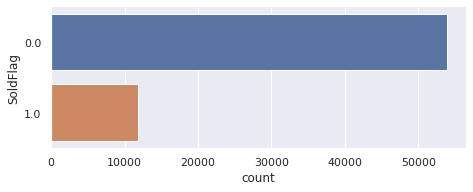

In [115]:
# Let's first look at how many SKUs have been sold in the last six months (soldflag=1)
sns.catplot(y="SoldFlag", kind="count", data=df_historical_abc, height=2.6, aspect=2.5)

It looks like approximately ~20% of historical SKUs have been sold in the last 6 months

#### Does the Price show significant difference for the historical and active products?

Text(0.5, 1.0, 'The Average Prices for Active and Historical Products')

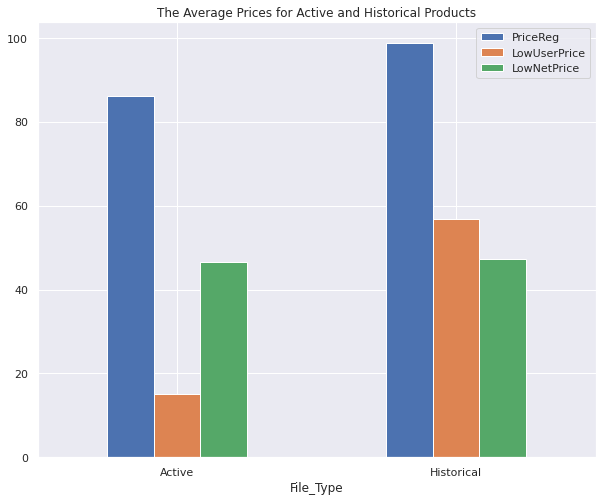

In [116]:
#We compare the averge PriceReg, LowUserPrice and LowNetPrice for historical and active products
sns.set(rc={'figure.figsize':(10,8)})
df_master.groupby('File_Type')[['PriceReg','LowUserPrice','LowNetPrice']].mean().reset_index().plot(x='File_Type',kind='bar')
plt.xticks(rotation=360)
plt.title("The Average Prices for Active and Historical Products")

The active and historical products have similar average LowNetPrice, but historical products have significant higher average PriceReg and LowUserPrice compare to active products.
In addition to the mean, we also calculate the standard deviation and median for each price.

In [117]:
#The comparison between active and historical products in median, standard deviation and mean for three prices.

prices = df_master.groupby('File_Type')[['PriceReg','LowUserPrice','LowNetPrice']].agg({'mean','median','std'})
prices

PriceReg                   LowUserPrice                    \
                  std median       mean          std median       mean   
File_Type                                                                
Active      91.008778  62.99  86.051032    16.501624   8.68  15.077402   
Historical  78.712358  78.95  98.730594   104.758351  44.03  56.708431   

           LowNetPrice                    
                   std median       mean  
File_Type                                 
Active      127.701997  32.98  46.613126  
Historical  129.814719  36.13  47.186160

From the results above, we could notice that except for LowNetPrice, the median and standard deviation for the other two prices show much difference in active and historical products. We could assuming that some products in current inventory significantly different from previous products in older inventories, or in other case, most of the products are seasonal goods, so their prices affected by time and season. Unfortunately we do not have any product category data to explain this further.

In addition, the standard deviation of the three prices for both active and historical products are pretty large, which means the price range for commodities is large to some extent. Perhaps even in same inventory, the types of products are significantly different. Such a wide range may become an issue as we develop prediction models.

#### How does price vary across historical SKUs that have and have not been sold in the last six months?

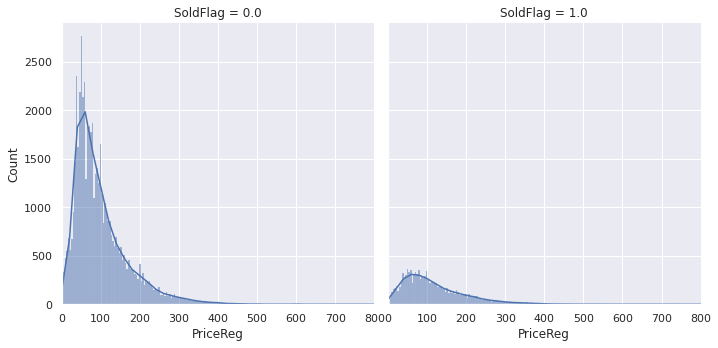

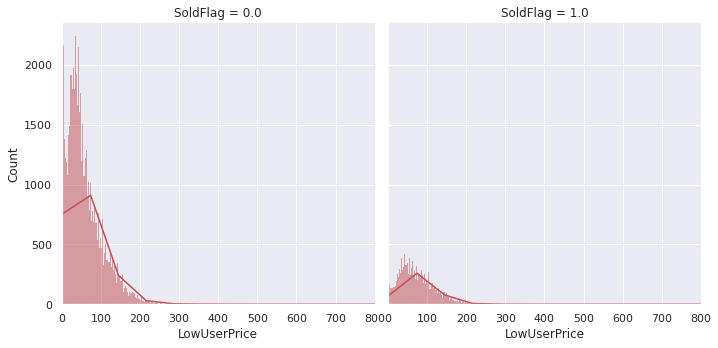

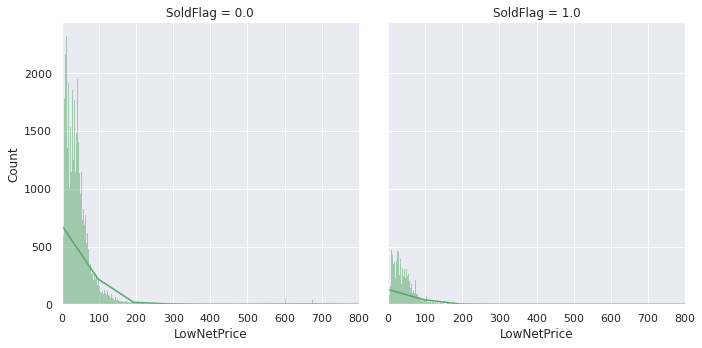

In [27]:
# Let's look at how the three price variables vary within SKUs that have and have not been sold in the last 6 months
sns.displot(x=df_historical_abc['PriceReg'], col=df_historical_abc["SoldFlag"], kde=True, color='b');
plt.xlim(0,800);
sns.displot(x=df_historical_abc['LowUserPrice'], col=df_historical_abc["SoldFlag"], kde=True, color='r');
plt.xlim(0, 800);
sns.displot(x=df_historical_abc['LowNetPrice'], col=df_historical_abc["SoldFlag"], kde=True, color='g');
plt.xlim(0,800);

We see a similar trend across all three price variables ("PriceReg", "LowUserPrice", "LowNetPrice"). There are many more SKUs that have not been sold than those that have been sold.  

Let's look at a table that aggregates the means of these prices for each SoldFlag category:

In [28]:
# Average "PriceReg", "LowUserPrice", and "LowNetPrice" grouped by SoldFlag==0 & SoldFlag==1
df_historical_abc.groupby('SoldFlag')[['PriceReg', 'LowUserPrice', 'LowNetPrice']].mean()

,PriceReg,LowUserPrice,LowNetPrice
SoldFlag,,,
0.0,99.576034,61.641269,47.905996
1.0,117.223887,75.662187,43.367738


After aggregating the price variables in the above table, we can confirm that that average price tends to be higher for SKUs that have been sold in the last six months for "PriceReg" and "LowUserPrice", but average "LowNetPrice" is slightly lower for these SKUs. In other words, we are seeing a discrepancy in how "LowNetPrice" varies across SKUs sold when compared to the other two price variables. Again, we do not know the specific definition of "LowNetPrice", but perhaps this discrepancy has to due with it being a "Net" price for the retailer and not a "sticker" price for the customer. Let's keep this in mind as we eventually build our model. Overall, we have identified that more expensive SKUs tend to sell more based on historical data.

#### Which marketing types sell more often?  
Next, let's take a look at how many SKUs with marketing types "D" and "S" have sold in the last six months.

In [29]:
#The order counts for active and historical products in marketing type D and S.

market_compare = df_master.groupby(['File_Type','MarketingType'])[['Order']].count()
market_compare

Order
File_Type  MarketingType       
Active     D              62852
           S              60069
Historical D              35119
           S              40877

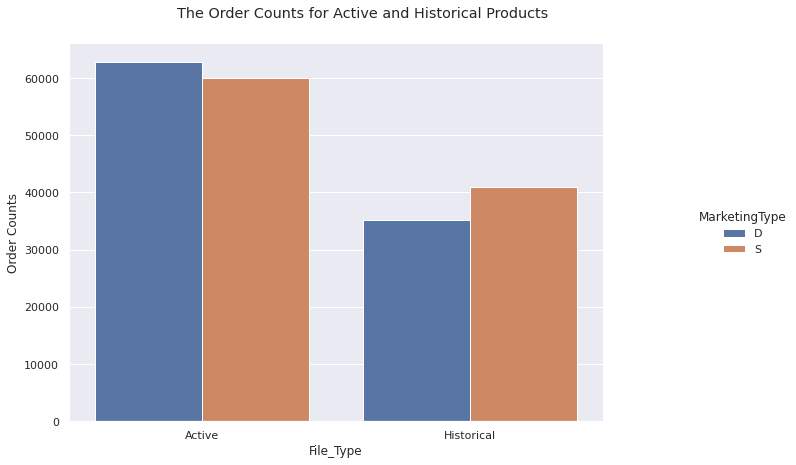

In [30]:
#The order counts for active and historical products in marketing type D and S (plot).

market_com = market_compare.reset_index()


g = sns.catplot(x = 'File_Type', y = 'Order', data = market_com, kind = 'bar',hue='MarketingType')
g.fig.suptitle("The Order Counts for Active and Historical Products",y = 1.05)
g.set(xlabel = 'File_Type', ylabel = 'Order Counts')
g.fig.set_figwidth(12)
g.fig.set_figheight(6)
plt.show()

For historical products, the market preference for type S products is higher than type D, on the contrary, type D take a larger proportion in active products rather than type S.
Next, we explore the sold count and not sold count for type D and type S products in the last 6 months, in order to find the reason why the porprotion of these two type goods are different in older and current inventories.

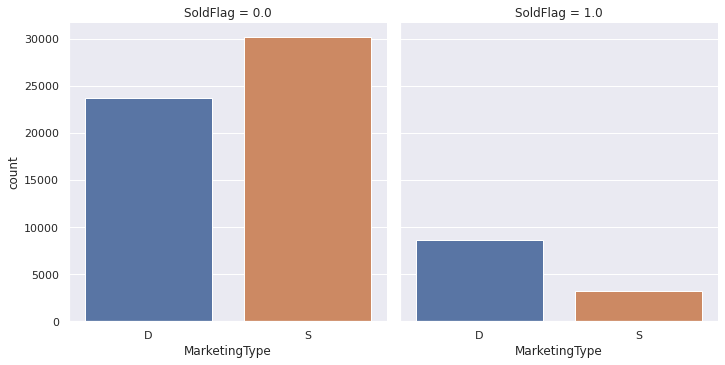

In [31]:
# Looking at marketing type counts for SKUs that have and have not been sold in the last 6 months
sns.catplot(x='MarketingType', kind="count", data=df_historical_abc, col='SoldFlag')

We already know that about 80% of historical SKUs have not been sold in the last six months, which we can clearly see in the larger bars where SoldFlag=0. However, within the ~20% of SKUs that have been sold in the last six months, we can see that SKUs with MarketingType "D" historically sold double than that of MarketingType "S". In other words, it looks like MarketingType "D" SKUs exhibit better sales performance. Let's take a look at how price varies across different marketing types.

In [32]:
df_historical_abc.groupby('MarketingType')[['PriceReg','LowUserPrice', 'LowNetPrice']].agg({'mean','std'})

PriceReg             LowUserPrice            LowNetPrice  \
                     std        mean          std       mean         std   
MarketingType                                                              
D              82.732507  112.836045   114.792314  75.415952  140.820084   
S              72.713099   92.975425   104.486752  53.258937   91.178271   

                          
                    mean  
MarketingType             
D              45.835953  
S              48.305535

We can notice that that average price tends to be higher for SKUs with MarketingType "D" in the last six months for "PriceReg" and "LowUserPrice" except for average "LowNetPrice", which confirms again that more expensive SKUs tend to sell more.

#### Do SKUs with a planned future release sell more often?  

Next, let's take a look at historical sales performance for SKUs with and without a planned future release.

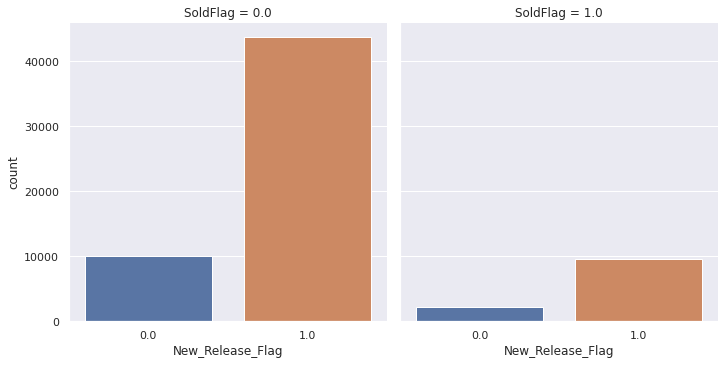

In [33]:
# Looking at sold and not sold counts for SKUs with and without plans for future release
sns.catplot(x='New_Release_Flag', kind="count", data=df_historical_abc, col='SoldFlag')

We can conclude two statements from this visualization. First, most historical SKUs have a planned future release. Second, SKUs with a planned future release exhibit better sales performance. We take this second point with a grain of salt since most SKUs have planned future release. While this important to take note of, we can also conclude from this that MarketingType may be a better indicator of sales performance than New_Release_Flag.

#### How do marketing type and price relate to sales performance?  

Let's confirm our two previous findings that marketing type "D" performs better than "S" and that more expensive SKUs sell more often.

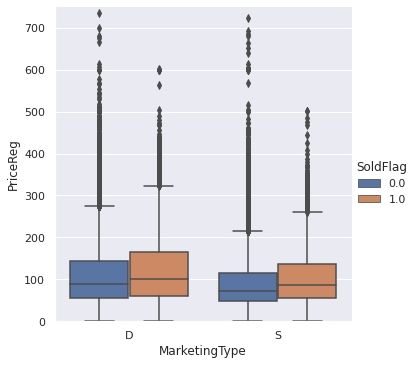

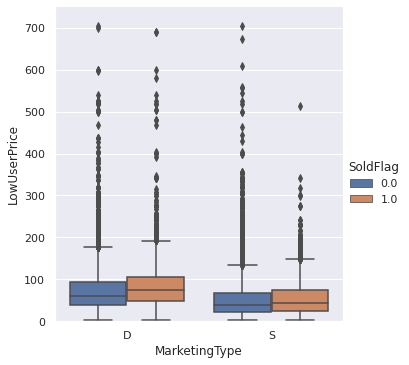

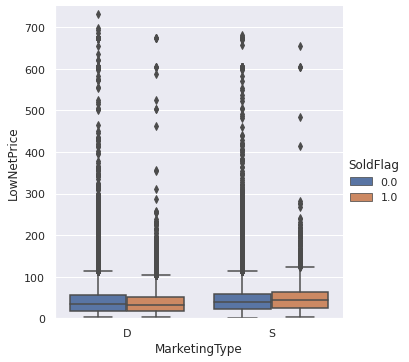

In [120]:
# Now let's combine price and marketing type to get a better understanding of how various price/marketing types sell. We'll show these plots separately so that it is easier to read.
sns.catplot(x="MarketingType", y="PriceReg", data=df_historical_abc, hue="SoldFlag", kind='box');
plt.ylim(0,750);
sns.catplot(x="MarketingType", y="LowUserPrice", data=df_historical_abc, hue="SoldFlag", kind='box');
plt.ylim(0,750);
sns.catplot(x="MarketingType", y="LowNetPrice", data=df_historical_abc, hue="SoldFlag", kind='box');
plt.ylim(0,750);

We see similar results to our prior investigation. For "PriceReg" and "LowUserPrice", median price is higher for SKUs that have been sold in the last six months within both MartketingType buckets and MarketingType "D" exhibits more sales. Again, we can see that "LowNetPrice" shows a discrepancy in this trend. Because of this discrepancy, and following mdneuzerling's advice, we can establish that "LowNetPrice" will not be our primary price feature as we move towards a prediction model. Let's dive deeper into price across both historical and active datasets.

#### Are there any other notable relationships between each variable?

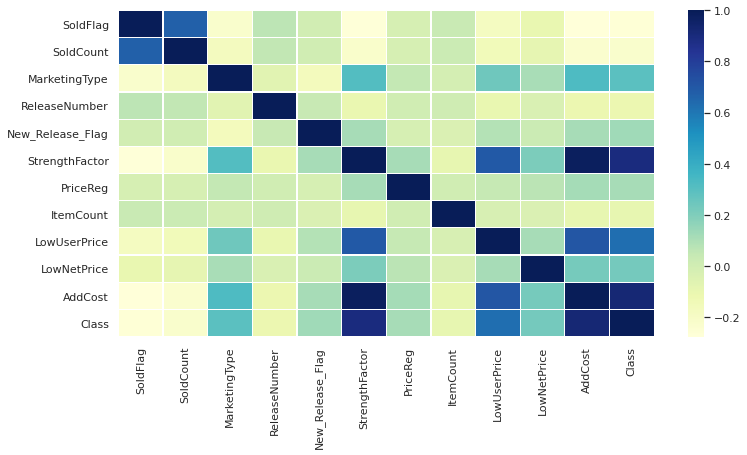

In [36]:
#We draw the corrlation plot for variables that might have protential corrlation between each other in historical data.

df1 = df_historical_abc.drop(['SKU_number', 'ReleaseYear','TotalSum'],
        axis=1)

plt.figure(figsize=(12, 6))
corr = df1.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

We notice that there exist corrlation between LowUserPrice and StrengthFactor, SoldCount and SoldFlag.  

#### How is the Class Feature related to the disribution of SoldFlag?

In [37]:
#replace stri as numerical value
df_ml=df_historical_abc.replace('D',1).replace('S',2).replace('A',3).replace('B',2).replace('C',1)

In [38]:
#select the numerical features
df_ml_num=df_ml[['SoldFlag','StrengthFactor','PriceReg'\
                ,'ItemCount','LowUserPrice','LowNetPrice','Class']]

In [39]:
#create sub set for ABC class
df_A=df_ml[df_ml['Class']==3].sort_values('LowUserPrice')
df_B=df_ml[df_ml['Class']==2].sort_values('LowUserPrice')
df_C=df_ml[df_ml['Class']==1].sort_values('LowUserPrice')

From the count plot below we can see that the the number of the soldFlag equal to 1 is roughly same across different classes but the SoldFlag equal to 0 are differed significatly across different classes, which the SoldFlag 1 and 0 ratio varied across different classes. And we can see the Class 3(A) has the highest SoldFlag 1 to 0 ratio

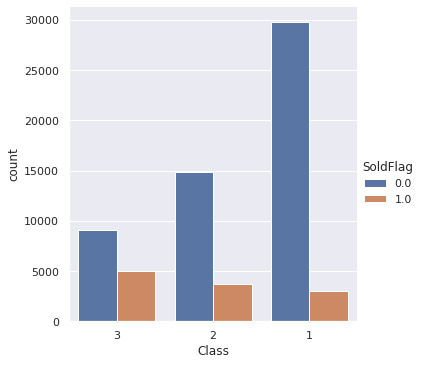

In [40]:
import seaborn as sns
sns.catplot(x="Class", kind="count", hue='SoldFlag', data=df_ml_num);

#### Is the ABC classification coming from a quality data set?

The ABC classifcation is developed from the Addvalue for each item in the inventroy. As the ABC classfication shows a correlation with the Soldflag, we need to validate the distribution of the Addvalue so we can insure to input quality data in our future prediction model. 


From the three box_plot below we find there are a lot of outliers in the 3(A) class with a large range of value but the other two class shows a very stable distribution of the value. The below box plots are in very different ranges, so we will show them in separate boxplots for each class.

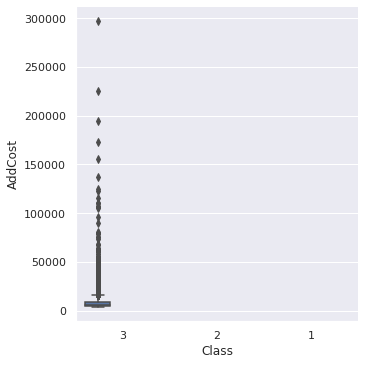

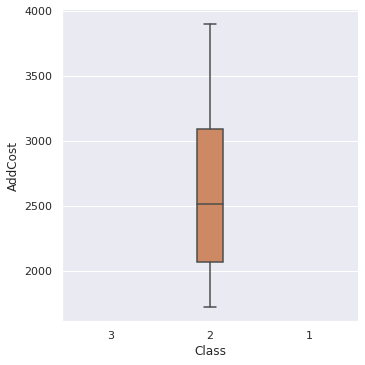

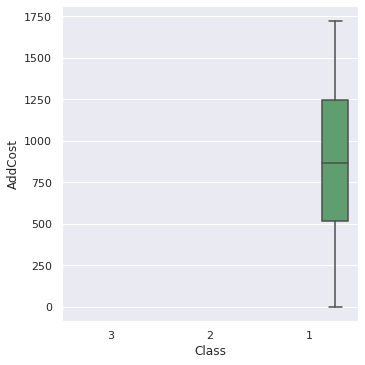

In [122]:
sns.catplot(data=df_A, x='Class', y='AddCost', hue='Class', kind='box')
sns.catplot(data=df_B,x='Class',y='AddCost',hue='Class',kind='box')
sns.catplot(data=df_C,x='Class',y='AddCost',hue='Class',kind='box')

#### How does StengthFactor relate to MarketingType, New_Release_Flag, and SoldFlag
We don't know exactly how StrengthFactor is defined, so let's take a look at how this variable interacts with other key features like MarketingType, ReleaseFlag, and SoldFlag.  

StrengthFactor and ReleaseFlag in Active Inventory for two different Marketing Types:

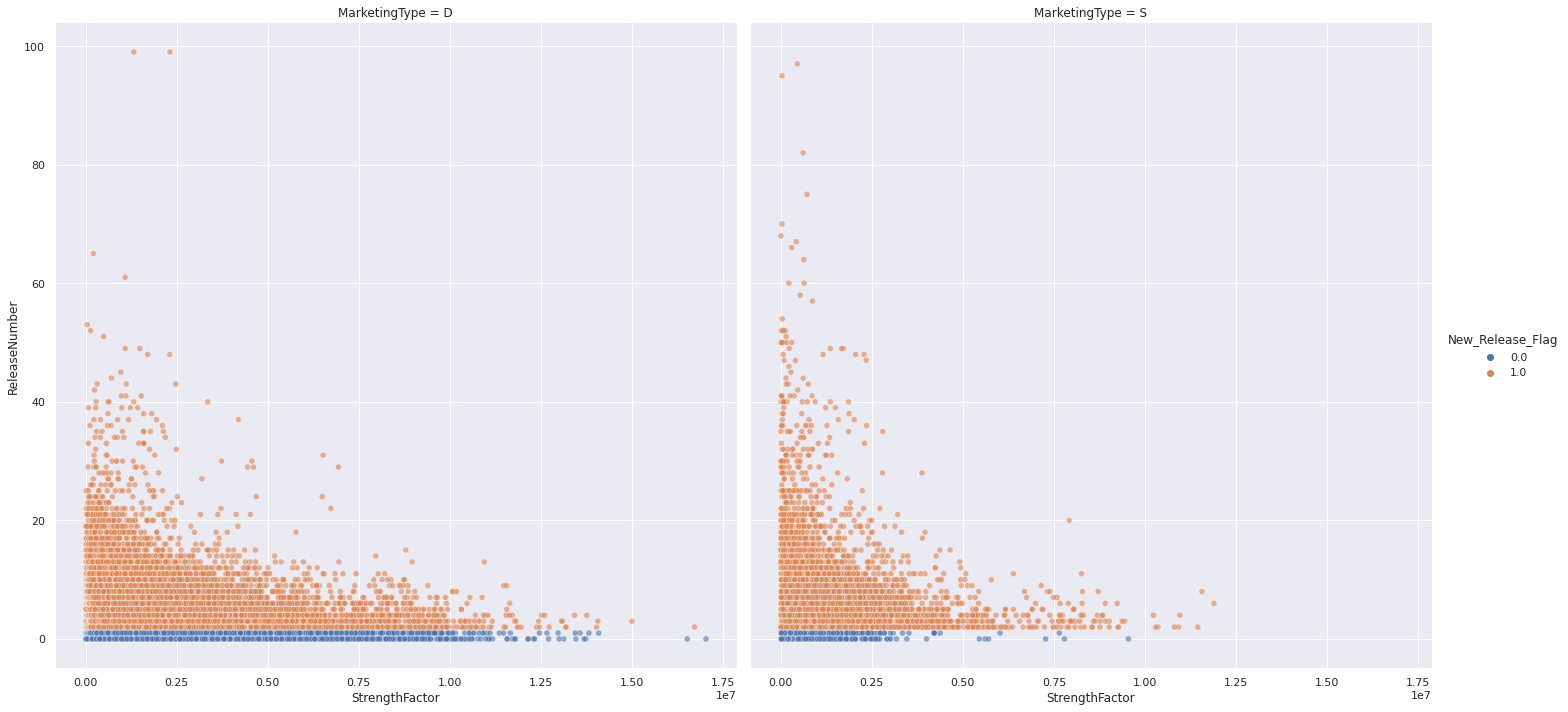

In [46]:
sns.relplot(data=df_active_abc, x='StrengthFactor', y='ReleaseNumber', height=10,
             col="MarketingType", hue="New_Release_Flag", alpha=0.6);

We can see that SKUs with MarketingType "D" have higher StrengthFactor on average for products with and without a future release plan. Now, let's look in the historical dataset to understand how StrengthFactor historically trends from a sales perspective.

ReleaseNumber with StrengthFactor in Historical Inventory for two different Marketing Types:

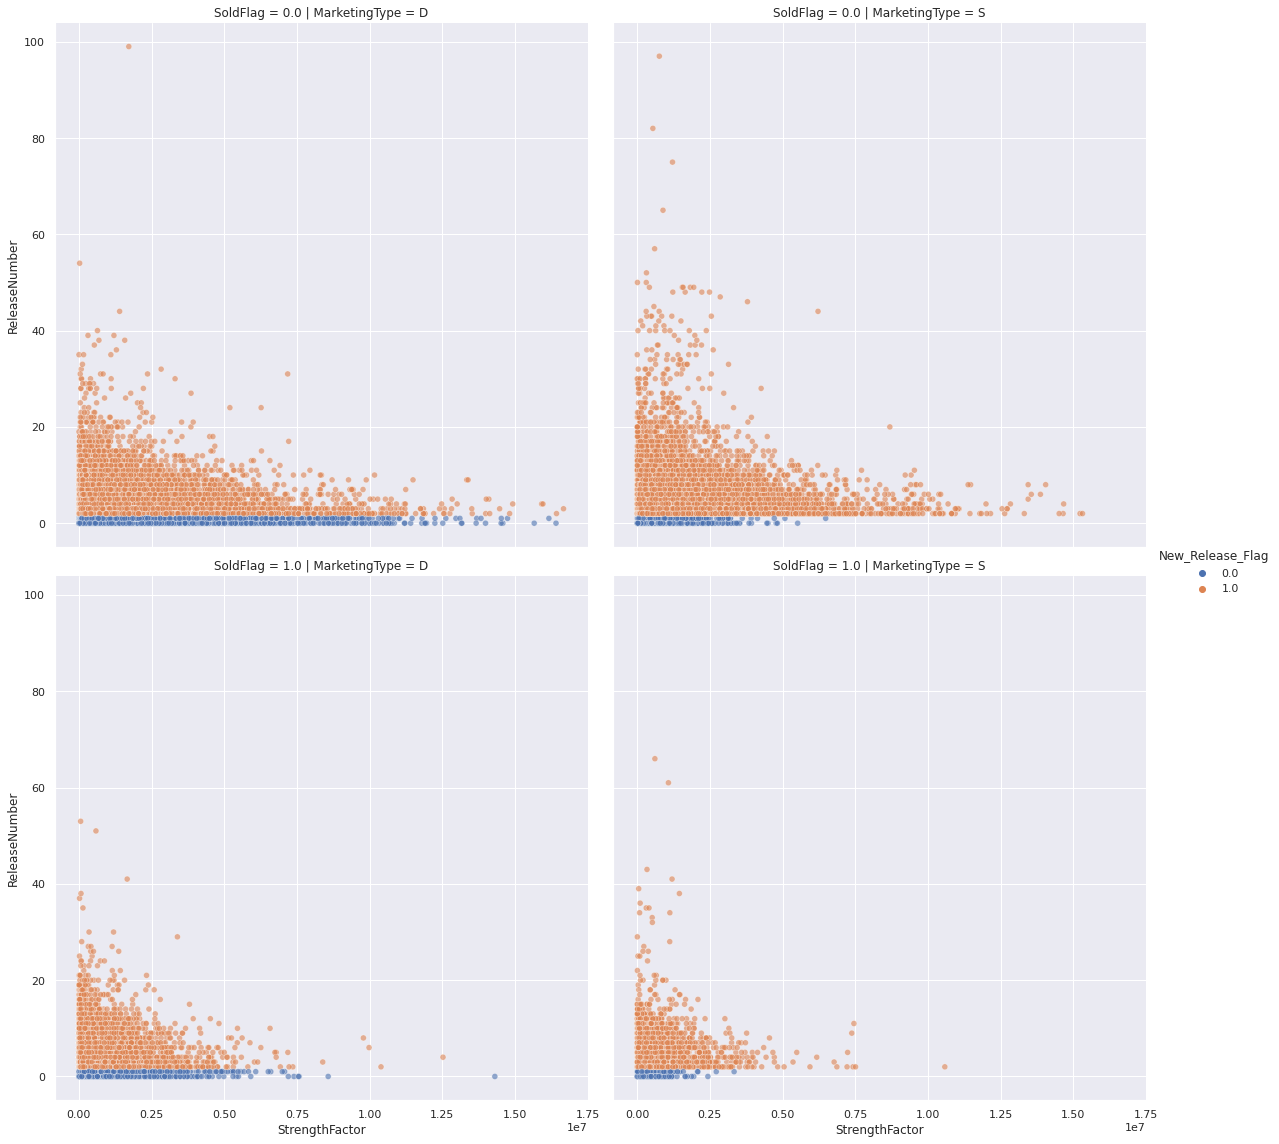

In [47]:
sns.relplot(data=df_historical_abc, x='StrengthFactor', y='ReleaseNumber', height=8,
            row='SoldFlag', col="MarketingType", hue="New_Release_Flag", alpha=0.6);

We see that for SKUs that have been sold in the last six months, MarketingType "D" SKUs have slightly higher StrengthFactor. Since we already know that MarketingType "D" performs better historically, it's not surprising that more "D" products have higher StrengthFactor values and "S" products.


#### How does price interact with StrengthFactor?

LowUserPricer with StrengthFactor in Active Inventory Data of two different Marketing Types:

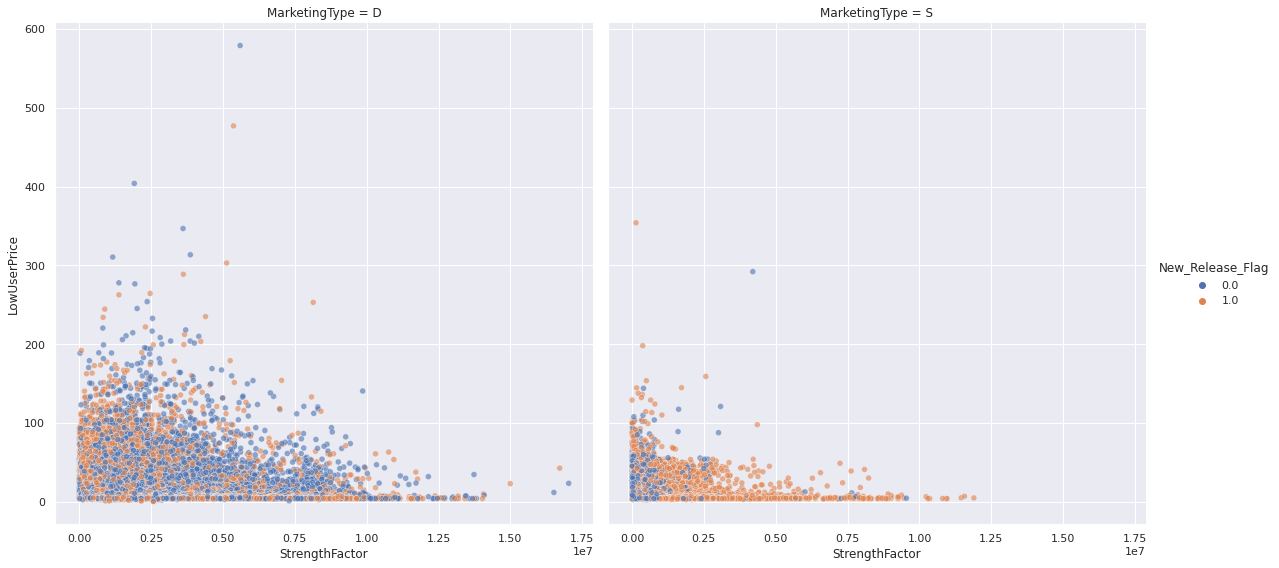

In [48]:
sns.relplot(data=df_active_abc, x='StrengthFactor', y='LowUserPrice', height=8,
             col="MarketingType", hue="New_Release_Flag", alpha=0.6);

From this we can see that SKUs with marketing type "D" and plans for a future release have higher strength factor and LowUserPrice. Finally, let's look at how strength factor, marketing type, and release flag relate to sales performance in the historical dataset.

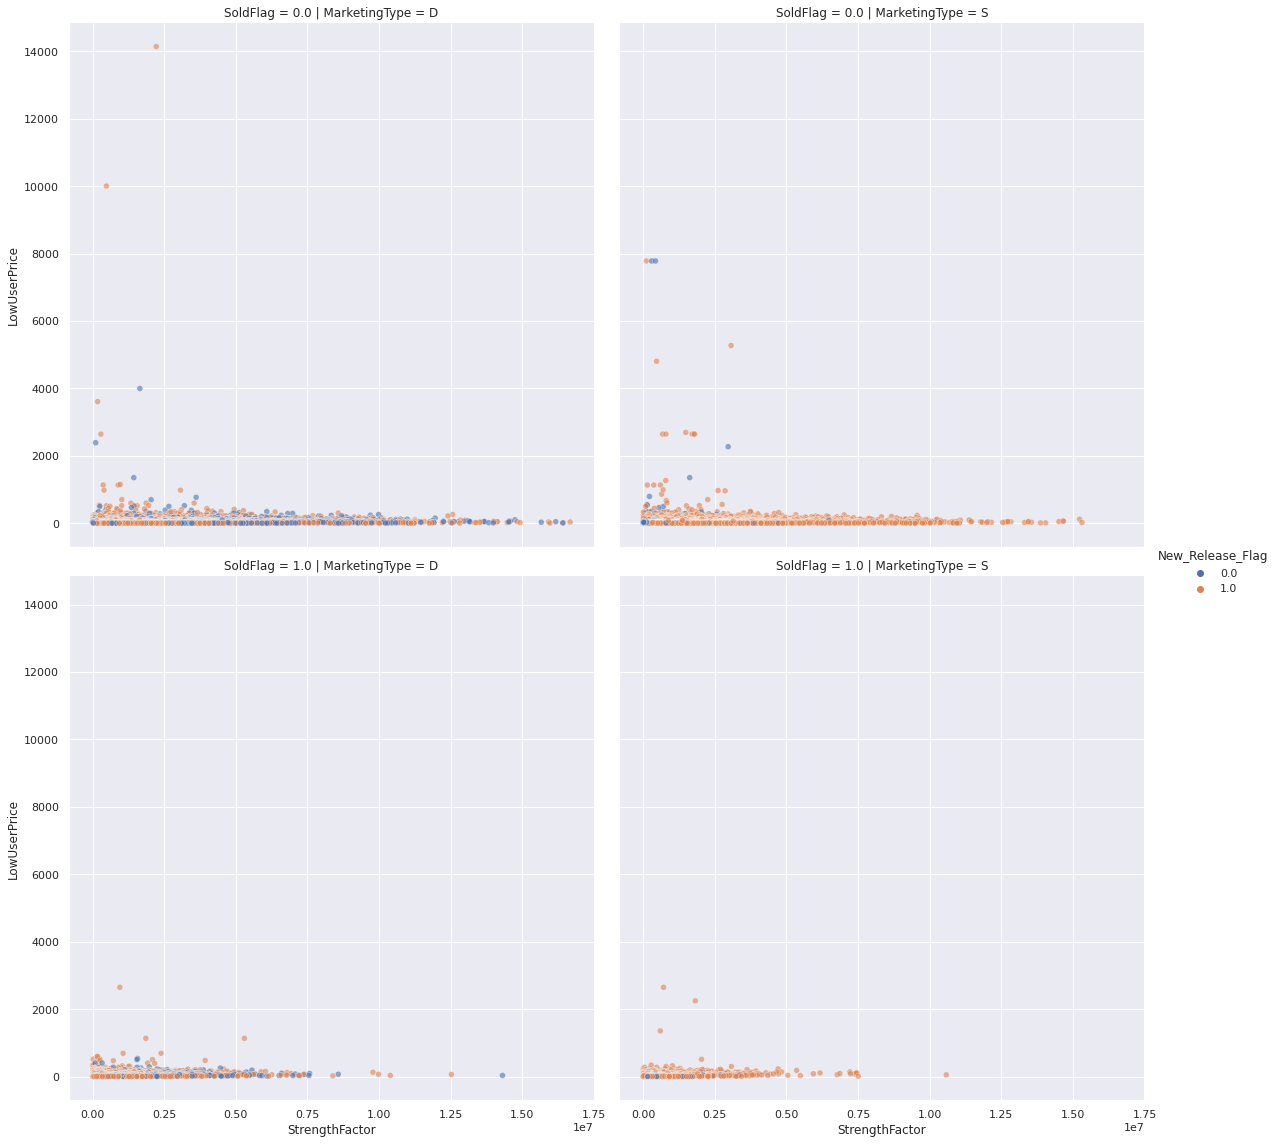

In [49]:
sns.relplot(data=df_historical_abc, x='StrengthFactor', y='LowUserPrice', height=8,
            row='SoldFlag', col="MarketingType", hue="New_Release_Flag", alpha=0.6);

From this, we can again see that LowUserPrice tends to be slightly higher for SKUs in MarketingType "D" that have been sold in the last six months, and that many of these SKUs have plans for a future release.

## EDA Conclusion  

From our initial analysis of variables, we can determine that MarketingType, StrengthFactor, New_Release_Flag and Price should all be considered as relevant features for our prediction model. 

## Prediction Models

Below we re-import the historical dataset and clean the data to prepare for our prediction models.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.cloud import storage
from sklearn import metrics
import math 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [28]:
download_blob(project_id="ba775-team-3a-291914", bucket_name="msba775-group", 
              source_blob_name="historical_ABC.csv", 
              destination_file_name="historical_ABC")

Blob historical_ABC.csv downloaded to historical_ABC.


In [51]:
df_historical_abc = pd.read_csv('historical_ABC')
df_historical_abc

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotalSum,RunPerc,Class
0,10814,Historical,618154,0,0,D,5,1,2219727,259.00,2002,21,14140.21,9.30,296944.41,2.969444e+05,197475980.5,0.001504,A
1,46977,Historical,545616,0,0,S,3,1,115726,77.95,2011,29,7781.01,51.49,225649.29,5.225937e+05,197475980.5,0.002646,A
2,73868,Historical,174356,0,0,S,0,0,300352,79.99,2004,25,7781.00,60.96,194525.00,7.171187e+05,197475980.5,0.003631,A
3,32426,Historical,132474,0,0,D,9,1,175474,170.20,2008,48,3608.97,28.03,173230.56,8.903493e+05,197475980.5,0.004509,A
4,54577,Historical,291246,0,0,S,0,0,431590,60.00,1997,20,7781.00,78.99,155620.00,1.045969e+06,197475980.5,0.005297,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75991,46724,Historical,3694767,0,0,S,15,1,281828,166.00,2016,10,0.00,87.94,0.00,1.974760e+08,197475980.5,1.000000,C
75992,46723,Historical,3694644,0,0,S,19,1,118085,79.00,2016,0,0.00,47.40,0.00,1.974760e+08,197475980.5,1.000000,C
75993,1317,Historical,1995730,0,0,D,24,1,75064,199.99,2016,11,0.00,120.26,0.00,1.974760e+08,197475980.5,1.000000,C
75994,46722,Historical,3694508,0,0,S,56,1,22803,85.00,2016,0,0.00,66.47,0.00,1.974760e+08,197475980.5,1.000000,C


# Logistic Regression

In [52]:
# convert "PriceReg"==0 into NaN values and drop from dataframe inplace
df_historical_abc[df_historical_abc['PriceReg'] == 0] = None
df_historical_abc.dropna(subset=['PriceReg'], inplace=True)

# convert "LowUserPrice"==0 into NaN values and drop from the dataframe inplace
df_historical_abc[df_historical_abc['LowUserPrice'] == 0] = None
df_historical_abc.dropna(subset=['LowUserPrice'], inplace=True)

# convert "LowNetPrice"==0 into NaN values and drop from the dataframe inplace
df_historical_abc[df_historical_abc['LowNetPrice'] == 0] = None
df_historical_abc.dropna(subset=['LowNetPrice'], inplace=True)

# reset the index
df_historical_abc.reset_index(drop=True)

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotalSum,RunPerc,Class
0,10814.0,Historical,618154.0,0.0,0.0,D,5.0,1.0,2219727.0,259.00,2002.0,21.0,14140.21,9.30,296944.41,2.969444e+05,197475980.5,0.001504,A
1,46977.0,Historical,545616.0,0.0,0.0,S,3.0,1.0,115726.0,77.95,2011.0,29.0,7781.01,51.49,225649.29,5.225937e+05,197475980.5,0.002646,A
2,73868.0,Historical,174356.0,0.0,0.0,S,0.0,0.0,300352.0,79.99,2004.0,25.0,7781.00,60.96,194525.00,7.171187e+05,197475980.5,0.003631,A
3,32426.0,Historical,132474.0,0.0,0.0,D,9.0,1.0,175474.0,170.20,2008.0,48.0,3608.97,28.03,173230.56,8.903493e+05,197475980.5,0.004509,A
4,54577.0,Historical,291246.0,0.0,0.0,S,0.0,0.0,431590.0,60.00,1997.0,20.0,7781.00,78.99,155620.00,1.045969e+06,197475980.5,0.005297,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65616,47622.0,Historical,2286696.0,0.0,0.0,S,0.0,0.0,20200.0,113.35,2014.0,0.0,26.87,134.44,0.00,1.974760e+08,197475980.5,1.000000,C
65617,62427.0,Historical,1989651.0,0.0,0.0,S,2.0,1.0,339676.0,39.99,2015.0,0.0,25.00,22.85,0.00,1.974760e+08,197475980.5,1.000000,C
65618,83910.0,Historical,858486.0,0.0,0.0,S,4.0,1.0,1363243.0,115.00,2015.0,0.0,93.73,108.19,0.00,1.974760e+08,197475980.5,1.000000,C
65619,68964.0,Historical,3462028.0,0.0,0.0,S,3.0,1.0,1377858.0,85.00,2016.0,0.0,78.99,63.33,0.00,1.974760e+08,197475980.5,1.000000,C


In [53]:
# dropping "Order" column
df_historical_abc.drop(['Order'], axis=1, inplace=True)

# change "File_Type" dtype to string
df_historical_abc.drop(['File_Type'], axis=1, inplace=True)

# change "SKU_number" dtype to string
df_historical_abc['SKU_number'] = df_historical_abc['SKU_number'].astype('str')

# change "SoldFlag" dtype to category
#df_historical_abc['SoldFlag'] = df_historical_abc['SoldFlag'].astype('category')

# change "MarketingType" dtype to category
df_historical_abc['MarketingType'] = df_historical_abc['MarketingType'].astype('category')

# change "New_Release_Flag" dtype to category
df_historical_abc['New_Release_Flag'] = df_historical_abc['New_Release_Flag'].astype('category')

# change "ReleaseYear" dtype to pd.datetime
#df_historical_abc['ReleaseYear'] = pd.to_datetime(df_historical_abc['ReleaseYear'], format='%Y')

# change "Class" dtype to category
df_historical_abc['Class'] = df_historical_abc['Class'].astype('category')

# drop "AddCost", "RunCumCost", "RunPerc" because they are arbitrary columns used to generate "Class"
df_historical_abc.drop(['AddCost'], axis=1, inplace=True)
df_historical_abc.drop(['RunCumCost'], axis=1, inplace=True)
df_historical_abc.drop(['RunPerc'], axis=1, inplace=True)

In [55]:
df_historical_abc.head()

,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,TotalSum,Class
0,618154.0,0.0,0.0,D,5.0,1.0,2219727.0,259.00,2002.0,21.0,14140.21,9.30,197475980.5,A
1,545616.0,0.0,0.0,S,3.0,1.0,115726.0,77.95,2011.0,29.0,7781.01,51.49,197475980.5,A
2,174356.0,0.0,0.0,S,0.0,0.0,300352.0,79.99,2004.0,25.0,7781.00,60.96,197475980.5,A
3,132474.0,0.0,0.0,D,9.0,1.0,175474.0,170.20,2008.0,48.0,3608.97,28.03,197475980.5,A
4,291246.0,0.0,0.0,S,0.0,0.0,431590.0,60.00,1997.0,20.0,7781.00,78.99,197475980.5,A


In [56]:
#Preprocessing: converting catergorical variables into dummy variables and deleting columns with no predictive power
lr_historical = df_historical_abc.drop(['SKU_number', 'TotalSum', 'ReleaseYear', 'LowNetPrice'],
        axis=1) #deleting columns with no predictive power
lr_historical = pd.get_dummies(lr_historical, columns=['MarketingType','Class']) #converting catergorical variables into dummy variables
lr_historical.drop(['MarketingType_D','Class_A'], axis=1, inplace=True)
lr_historical.head()

,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ItemCount,LowUserPrice,MarketingType_S,Class_B,Class_C
0,0.0,0.0,5.0,1.0,2219727.0,259.00,21.0,14140.21,0,0,0
1,0.0,0.0,3.0,1.0,115726.0,77.95,29.0,7781.01,1,0,0
2,0.0,0.0,0.0,0.0,300352.0,79.99,25.0,7781.00,1,0,0
3,0.0,0.0,9.0,1.0,175474.0,170.20,48.0,3608.97,0,0,0
4,0.0,0.0,0.0,0.0,431590.0,60.00,20.0,7781.00,1,0,0


We try to apply log-transformation to 'PriceReg' and 'LowUserPrice' since the large ranges of these variables would affect the accuracy of regression model.

In [57]:
lr_historical['PriceReg'] = np.log(lr_historical['PriceReg'])
lr_historical['LowUserPrice'] = np.log(lr_historical['LowUserPrice'])

<AxesSubplot:xlabel='LowUserPrice', ylabel='Count'>

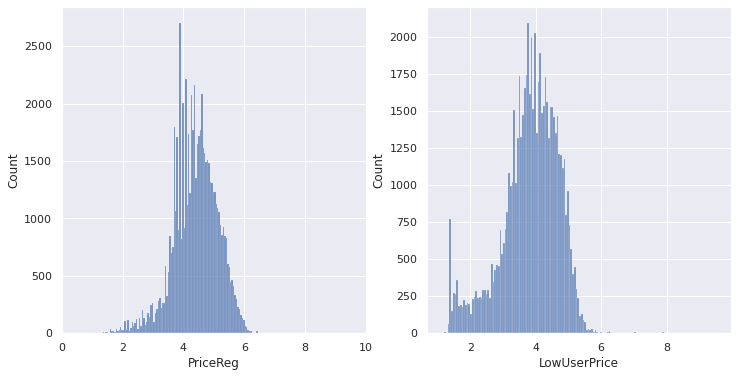

In [58]:
sns.set(rc={'figure.figsize':(12,6)})
fig, ax = plt.subplots(1,2)
g=sns.histplot(x=lr_historical['PriceReg'],data=lr_historical,ax=ax[0])
g.set(xlim=(0,10))
sns.histplot(x=lr_historical['LowUserPrice'],data=lr_historical,ax=ax[1])

In [59]:
#Create feature matrix X and target vector y
X = lr_historical.drop('SoldFlag', axis=1)
X.shape #check the shape of X

(65621, 10)

In [60]:
y = lr_historical['SoldFlag']
y.shape #check the shape of y

(65621,)

In [61]:
#Split the data into train and test with a 70-30 split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=5, 
 stratify=y) #the stratify = y retains the same proportion of classes (0 and 1) in the train and test sets that are found in the entire original dataset.

In [62]:
#Instantiate and fit the model 
lr_model = LogisticRegression(solver='liblinear') 

In [63]:
lr_model.fit(Xtrain, ytrain)

LogisticRegression(solver='liblinear')

In [64]:
#Make predictions
y_lr_model = lr_model.predict(Xtest)

In [65]:
#Get the specific predicted probability of classification for each observation
y_lr_model_prob = lr_model.predict_proba(Xtest)[:,1]
y_lr_model_prob=pd.DataFrame(y_lr_model_prob)
y_lr_model_prob

,0
0,0.464866
1,0.459331
2,0.086763
3,0.360323
4,0.452678
...,...
19682,0.450279
19683,0.394626
19684,0.000117
19685,0.419237


In [66]:
len(y_lr_model_prob[y_lr_model_prob[0]>=0.5]) #check if any result higher than 0.5

0

We can notice that the probabilities are all lower than 0.5, so if we classify the SoldFlag with the default classification threshold 0.5, that would classify all the observations as SoldFlag=0. So we would like to change the threshold.

In [67]:
#Create an optimal threshold to classify the obervations instead of using default value 0.5
fpr, tpr, thresholds = metrics.roc_curve(ytest,y_lr_model_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx] 

In [68]:
#Predict the labels of classification using the optimal threshold 
predicted = (y_lr_model_prob >= optimal_threshold).astype('int')
predicted_num=np.array(predicted).reshape(predicted.shape[0],)
lr_test = Xtest.join(ytest).reset_index(drop=True)
lr_test=lr_test.join(pd.Series(predicted_num, name='predicted'))

In [69]:
lr_test.head()

,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ItemCount,LowUserPrice,MarketingType_S,Class_B,Class_C,SoldFlag,predicted
0,0.0,1.0,0.0,112235.0,3.688629,34.0,2.830268,1,0,1,0.0,1
1,0.0,9.0,1.0,129988.0,5.327633,70.0,4.485711,0,0,0,0.0,1
2,0.0,10.0,1.0,1876684.0,2.918311,34.0,3.019937,1,0,1,0.0,0
3,0.0,4.0,1.0,457618.0,4.348987,45.0,4.316688,0,1,0,0.0,1
4,0.0,1.0,0.0,151370.0,5.248759,128.0,5.182514,0,0,0,0.0,1


In [70]:
#Accuracy
accuracy_score(ytest, predicted)

0.6256412861279017

In [71]:
#Sensitivity (true positive rate)
P = sum(ytest == 1)
TP = lr_test[lr_test['SoldFlag']==1]
TP=TP[TP['predicted']==1]
TP=int(TP.shape[0])
TP/P

0.5938383267382702

In [72]:
#Specificity (true negative rate)
N = sum(ytest == 0)
TN = lr_test[lr_test['SoldFlag']==0]
TN=TN[TN['predicted']==0]
TN=int(TN.shape[0])
TN/N

0.6326088302681281

In [73]:
#ROC accuracy score
a=roc_auc_score(ytest, predicted)
a

0.6132235785031992

#### Model Summary

After training the model, we are able to achieve 62% accuracy rate on our test dataset. We achieved a 59% true positive rate, meaning of all the SoldFlag=1 predictions the model made, 59% of the were true. Of all the SoldFlag=0 predeictions the model made, 63% of them were true. Since this is a logistic regression, were know that we are limited in creating a very robust model that can deal with wide ranges and outliers, which our data contains. While we can still make predictions for the active dataset, we will try building a Random Forest predictive model as well.

#### Predictions for Active Dataset Using Logistic Regression Model

In [74]:
# re-importing the active dataset and preprocessing to prepare for prediction
df_active_abc = pd.read_csv('active_ABC')
df_active_abc

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotSum,RunPerc,Class
0,141927,Active,540670,NaN,NaN,S,3,1,1.443928e+03,298.00,2013,274,46.49,70.99,12738.26,12738.26,58985115.47,0.000216,A
1,126396,Active,610364,NaN,NaN,S,7,1,6.417150e+02,300.95,2014,202,50.05,60.97,10110.10,22848.36,58985115.47,0.000387,A
2,138926,Active,543726,NaN,NaN,S,4,1,9.508895e+03,115.00,2013,120,84.23,74.00,10107.60,32955.96,58985115.47,0.000559,A
3,103301,Active,2185992,NaN,NaN,D,0,0,1.175402e+06,189.00,2009,97,102.81,117.70,9972.57,42928.53,58985115.47,0.000728,A
4,185607,Active,315714,NaN,NaN,D,0,0,6.317052e+03,125.00,2010,200,45.52,71.23,9104.00,52032.53,58985115.47,0.000882,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122916,111257,Active,3136590,NaN,NaN,S,13,1,4.757360e+05,29.95,2016,0,0.00,16.81,0.00,58985115.47,58985115.47,1.000000,C
122917,85160,Active,3960742,NaN,NaN,S,0,0,8.275000e+04,97.95,2017,0,0.00,77.78,0.00,58985115.47,58985115.47,1.000000,C
122918,85112,Active,862455,NaN,NaN,S,3,1,6.576754e+06,97.25,2017,0,0.00,85.95,0.00,58985115.47,58985115.47,1.000000,C
122919,85128,Active,3644308,NaN,NaN,S,4,1,1.738445e+07,95.95,2017,0,0.00,95.95,0.00,58985115.47,58985115.47,1.000000,C


In [75]:
# convert "PriceReg"==0 into NaN values and drop from dataframe inplace
df_active_abc[df_active_abc['PriceReg'] == 0] = None
df_active_abc.dropna(subset=['PriceReg'], inplace=True)

# convert "LowUserPrice"==0 into NaN values and drop from the dataframe inplace
df_active_abc[df_active_abc['LowUserPrice'] == 0] = None
df_active_abc.dropna(subset=['LowUserPrice'], inplace=True)

# convert "LowNetPrice"==0 into NaN values and drop from the dataframe inplace
df_active_abc[df_active_abc['LowNetPrice'] == 0] = None
df_active_abc.dropna(subset=['LowNetPrice'], inplace=True)

# convert "ReleaseYear"==0 into NaN values and drop from the dataframe inplace
df_active_abc[df_active_abc['ReleaseYear'] == 0] = None
df_active_abc.dropna(subset=['ReleaseYear'], inplace=True)

# reset the index
df_active_abc.reset_index(drop=True)

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotSum,RunPerc,Class
0,141927.0,Active,540670.0,NaN,NaN,S,3.0,1.0,1.443928e+03,298.00,2013.0,274.0,46.49,70.99,12738.26,12738.26,58985115.47,0.000216,A
1,126396.0,Active,610364.0,NaN,NaN,S,7.0,1.0,6.417150e+02,300.95,2014.0,202.0,50.05,60.97,10110.10,22848.36,58985115.47,0.000387,A
2,138926.0,Active,543726.0,NaN,NaN,S,4.0,1.0,9.508895e+03,115.00,2013.0,120.0,84.23,74.00,10107.60,32955.96,58985115.47,0.000559,A
3,103301.0,Active,2185992.0,NaN,NaN,D,0.0,0.0,1.175402e+06,189.00,2009.0,97.0,102.81,117.70,9972.57,42928.53,58985115.47,0.000728,A
4,185607.0,Active,315714.0,NaN,NaN,D,0.0,0.0,6.317052e+03,125.00,2010.0,200.0,45.52,71.23,9104.00,52032.53,58985115.47,0.000882,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117555,100511.0,Active,743718.0,NaN,NaN,D,6.0,1.0,5.130756e+06,59.95,2006.0,3.0,4.00,8.99,12.00,58985049.21,58985115.47,0.999999,C
117556,87878.0,Active,875427.0,NaN,NaN,D,0.0,0.0,2.586542e+06,80.24,2012.0,12.0,0.69,76.54,8.28,58985090.47,58985115.47,1.000000,C
117557,140700.0,Active,110603.0,NaN,NaN,D,5.0,1.0,2.578738e+06,48.99,2009.0,22.0,0.27,43.89,5.94,58985104.63,58985115.47,1.000000,C
117558,93798.0,Active,2843232.0,NaN,NaN,D,1.0,0.0,6.895237e+06,58.95,2003.0,1.0,4.89,9.49,4.89,58985109.52,58985115.47,1.000000,C


In [76]:
#Preprocessing: converting catergorical variables into dummy variables and deleting columns with no predictive power
lr_active = df_active_abc.drop(['Order','File_Type', 'SKU_number','TotSum', 'AddCost','RunCumCost','RunPerc','ReleaseYear', 'LowNetPrice'],
        axis=1) #deleting columns with no predictive power
lr_active = pd.get_dummies(lr_active, columns=['MarketingType','Class']) #converting catergorical variables into dummy variables
lr_active.drop(['MarketingType_D','Class_A'], axis=1, inplace=True)
lr_active['SoldCount'] = lr_active['SoldCount'].fillna(0) #convert NaN to 0 in 'SoldCount' column
lr_active.head()

,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ItemCount,LowUserPrice,MarketingType_S,Class_B,Class_C
0,NaN,0.0,3.0,1.0,1.443928e+03,298.00,274.0,46.49,1,0,0
1,NaN,0.0,7.0,1.0,6.417150e+02,300.95,202.0,50.05,1,0,0
2,NaN,0.0,4.0,1.0,9.508895e+03,115.00,120.0,84.23,1,0,0
3,NaN,0.0,0.0,0.0,1.175402e+06,189.00,97.0,102.81,0,0,0
4,NaN,0.0,0.0,0.0,6.317052e+03,125.00,200.0,45.52,0,0,0


In [77]:
#Create feature matrix X 
X = lr_active.drop('SoldFlag', axis=1)
X.shape #check the shape of X

(117560, 10)

In [78]:
#Get the specific predicted probability of classification for each observation
y_lr_model_prob = lr_model.predict_proba(X)[:,1]
y_lr_model_prob=pd.DataFrame(y_lr_model_prob)
y_lr_model_prob

,0
0,0.499547
1,0.499799
2,0.497018
3,0.186299
4,0.498019
...,...
117555,0.001602
117556,0.037538
117557,0.037893
117558,0.000175


In [79]:
#Predict the labels of classification using the optimal threshold created before
predicted = (y_lr_model_prob >= optimal_threshold).astype('int')
predicted_num=np.array(predicted).reshape(predicted.shape[0],)

#Add the predicted label(SoldFlag) to the active dataset
lr_pred_active=df_active_abc.join(pd.Series(predicted_num, name='Predicted SoldFlag'))
first_col = lr_pred_active.pop('Predicted SoldFlag')
lr_pred_active.insert(0,'Predicted SoldFlag',first_col)
lr_pred_active.drop('SoldFlag',axis=1,inplace=True)

In [80]:
lr_pred_active.head()

,Predicted SoldFlag,Order,File_Type,SKU_number,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotSum,RunPerc,Class
0,1.0,141927.0,Active,540670.0,NaN,S,3.0,1.0,1.443928e+03,298.00,2013.0,274.0,46.49,70.99,12738.26,12738.26,58985115.47,0.000216,A
1,1.0,126396.0,Active,610364.0,NaN,S,7.0,1.0,6.417150e+02,300.95,2014.0,202.0,50.05,60.97,10110.10,22848.36,58985115.47,0.000387,A
2,1.0,138926.0,Active,543726.0,NaN,S,4.0,1.0,9.508895e+03,115.00,2013.0,120.0,84.23,74.00,10107.60,32955.96,58985115.47,0.000559,A
3,0.0,103301.0,Active,2185992.0,NaN,D,0.0,0.0,1.175402e+06,189.00,2009.0,97.0,102.81,117.70,9972.57,42928.53,58985115.47,0.000728,A
4,1.0,185607.0,Active,315714.0,NaN,D,0.0,0.0,6.317052e+03,125.00,2010.0,200.0,45.52,71.23,9104.00,52032.53,58985115.47,0.000882,A


From the predicted result above, we could clearly know the SoldFlag that we predicted for each product in active inventory. Generally speaking, the prediction result could also achieve approximately 62% accuracy rate (62% reference value). To get higher predicted accuracy, we build the Random Forest predictive model in the next part.

## Random Forest Model

In [81]:
# Re-importing the dataset and establishing model imports
from google.cloud import storage
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from time import time

In [82]:
df_historical_abc = pd.read_csv('historical_ABC') #read data from historical_ABC
df_historical_abc.head() #show data

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotalSum,RunPerc,Class
0,10814,Historical,618154,0,0,D,5,1,2219727,259.00,2002,21,14140.21,9.30,296944.41,296944.41,197475980.5,0.001504,A
1,46977,Historical,545616,0,0,S,3,1,115726,77.95,2011,29,7781.01,51.49,225649.29,522593.70,197475980.5,0.002646,A
2,73868,Historical,174356,0,0,S,0,0,300352,79.99,2004,25,7781.00,60.96,194525.00,717118.70,197475980.5,0.003631,A
3,32426,Historical,132474,0,0,D,9,1,175474,170.20,2008,48,3608.97,28.03,173230.56,890349.26,197475980.5,0.004509,A
4,54577,Historical,291246,0,0,S,0,0,431590,60.00,1997,20,7781.00,78.99,155620.00,1045969.26,197475980.5,0.005297,A


In [83]:
##Data cleaning
df_historical_abc.drop(['Order'], axis=1, inplace=True) #Drop columns with no predicted power
df_historical_abc.drop(['File_Type'], axis=1, inplace=True) #Drop columns with no predicted power
df_historical_abc.drop(['AddCost'], axis=1, inplace=True) #Drop columns which represent same thing with Class feature
df_historical_abc.drop(['RunCumCost'], axis=1, inplace=True) #Drop columns which represent same thing with Class feature
df_historical_abc.drop(['RunPerc'], axis=1, inplace=True) #Drop columns which represent same thing with Class feature
df_historical_abc.drop(['TotalSum'], axis=1, inplace=True) #Drop columns which represent same thing with Class feature
df_historical_abc.drop(['SoldCount'], axis=1, inplace=True) #Drop columns which is the other value we want to predict and it only exist in non-zero when the sold flag is 1.

In [84]:
rf_historical = df_historical_abc.drop(['SKU_number','ReleaseYear'],
        axis=1) #Drop columns with no predicted power
rf_historical = pd.get_dummies(rf_historical, columns=['MarketingType','Class'])

In [85]:
# create train and test set
X = rf_historical.drop(columns=['SoldFlag'])#predicting dataframe
y = rf_historical['SoldFlag']#Lable
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=5) #train and test split

#### Hyperparameter Tuning 

In [86]:
#hyper-parameter tunning through random-search
rf_model = RandomForestClassifier()#reinitialize the parameter
# create the set of parameter to tunn
param_dist = {'n_estimators': [*range(5, 600, 50)],
              'max_depth': [*range(5, 15, 1)],
              'min_samples_leaf': [1,2,3],
             'max_features':['auto', 'sqrt', 'log2'],
             'random_state':[0,1]}
n_iter_search = 20 #number of the interation of the random search
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist,
                                   n_iter=n_iter_search)# compile the random search with model
def report(results, n_top=3):# define the function used to report the top 3 performed hyper-parameter setting
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

start = time() #time the running time
random_search.fit(x_test, y_test) #fit the random search
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search)) #print the state of the search
report(random_search.cv_results_)#display report 

RandomizedSearchCV took 253.77 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.837 (std: 0.003)
Parameters: {'random_state': 1, 'n_estimators': 505, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 6}

Model with rank: 2
Mean validation score: 0.836 (std: 0.003)
Parameters: {'random_state': 1, 'n_estimators': 405, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.836 (std: 0.002)
Parameters: {'random_state': 1, 'n_estimators': 405, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 9}

Model with rank: 3
Mean validation score: 0.836 (std: 0.003)
Parameters: {'random_state': 0, 'n_estimators': 255, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5}



In [87]:
#create and fit model
rf_model = RandomForestClassifier(random_state= 877, 
                                  n_estimators=455,
                                  min_samples_leaf= 1, 
                                  max_features= 'auto', 
                                  max_depth= 7)# create model
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=455, random_state=877)

In [88]:
cv_results = cross_validate(rf_model, x_train, y_train, cv=3,
                    scoring= 'roc_auc',
                    return_train_score=True,
                    return_estimator =True)#validating performance with corss validation 
cv_results

{'fit_time': array([16.4438858 , 16.50501013, 16.13188529]),
 'score_time': array([0.84930372, 0.9064784 , 0.88766336]),
 'estimator': (RandomForestClassifier(max_depth=7, n_estimators=455, random_state=877),
  RandomForestClassifier(max_depth=7, n_estimators=455, random_state=877),
  RandomForestClassifier(max_depth=7, n_estimators=455, random_state=877)),
 'test_score': array([0.75861241, 0.75721627, 0.75490971]),
 'train_score': array([0.78122111, 0.78188281, 0.78292098])}

max_depth shows the maximum depth of the tree.
min_samples_leaf shows the minimum number of samples required to be at a leaf node, defult is 1, with more sample in dataset, we can give a higher min_samples_leaf.
n_estimators is the number of decision trees, more is better, but will have a negitive influence on performance.
test_score shows the score array for test scores on each cv split.  
train_score shows the score array for train score on each cv split.

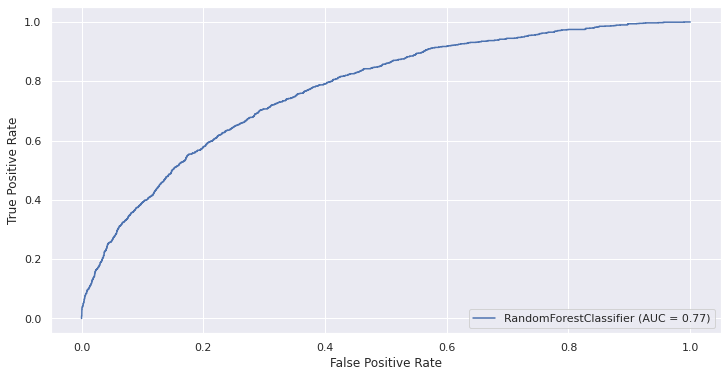

0.5437471502308283 0.7044100193139532


In [89]:
#Fitting to the Training set
result_bin=rf_model.predict(x_test)
result=rf_model.predict_proba(x_test)[:,1] #predict the value for the active set and extract the score of the row equal to 1
result=pd.DataFrame(result)

from sklearn import metrics
import math    
# extract the false postive, true positive and  thresholds value from Roc-curve
fpr, tpr, thresholds = metrics.roc_curve(y_test,result) 
# find the index of the max true positive-false postive
optimal_idx = np.argmax(tpr - fpr)
# extract the threshold on that index
optimal_threshold = thresholds[optimal_idx]
#use that threshold to classify probabilty to binary decision
predicted = (result >= optimal_threshold).astype('int') 
#caculate ROC_auc for dafult cutoff and optimized cutoff 
None_optimazation=roc_auc_score(y_test, result_bin)
With_optimazation=roc_auc_score(y_test, predicted)
#plot out the ROC curve on the model
metrics.plot_roc_curve(rf_model, x_test, y_test)
plt.show() 
#print ROC_score for both dafult cutoff and optimized cutoff
print(None_optimazation,With_optimazation)

In [121]:
optimal_threshold

0.16662082772880946

Before the optimazation, our defult model ROC accuracy score is 0.54, but after optimazation, our ROC accuracy score rise up to 0.70. This is a large improvement over the logistic regression model as a random forest model with an optimized threshold is better able to handle outliers. Next let's observe the sensitivity and specificity of the model.

In [90]:
#Sensitivity True positive rate
predicted_np=np.array(predicted)
predicted_np=predicted_np.reshape(predicted_np.shape[0],)
P = sum(y_test == 1) #Count of all positives
TP_D = sum((y_test == 1) & (result_bin == 1)) #Threshold
TP = sum((y_test == 1) & (predicted_np == 1)) #True positives model generate
print('Sensitivity with no threshold optimization:',TP_D/P)
print('Sensitivity with threshold optimization:',TP/P)

Sensitivity with no threshold optimization: 0.09877488514548238
Sensitivity with threshold optimization: 0.7029096477794793


In [91]:
# specificity True negative rate
N = sum(y_test == 0) #count of all negatives
TN_D = sum((y_test == 0) & (result_bin == 0)) #Threshold
TN = sum((y_test == 0) & (predicted_np == 0)) #True negatives model generate
print('specificity with no threshold optimization:', TN_D/N)
print('specificity with threshold optimization:',TN/N)

specificity with no threshold optimization: 0.9887194153161741
specificity with threshold optimization: 0.7059103908484271


We achieved a 69% true positive rate after optimization, meaning of all the SoldFlag=1 predictions the model made, 69% of them were true. Of all the SoldFlag=0 predeictions the model made, 99% of them were true before optimization, but 71.6% accuracy of SoldFlag = 0 after optimization. Let's now visualize the influence and predictive power some variables have in this optimized model.

In [92]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


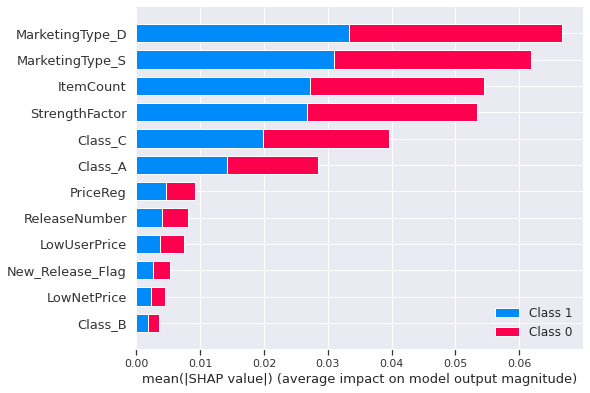

In [93]:
import shap
# load JS visualization code to notebook
shap.initjs()
# select a set of background examples to take an expectation over
background=x_train[1:100]
# explain predictions of the model
e = shap.TreeExplainer(rf_model,background)
# ...or pass tensors directly
shap_values = e.shap_values(background,check_additivity=False)
# summarize the effects of all the features
shap.summary_plot(shap_values, x_test,plot_size='auto')
##shap.force_plot(e.expected_value[0], shap_values[0], x_test)


#### Features Importance:
Blue bar represents SoldFlag = 0. Red bar represents SoldFlag = 1.
It seems that the top six most important features are

- Marketing Type D, Marketing Type S, Itemcount, StrengthFactor, Class C and Class A.

It is interesting that Class C has a relatively higher importance rate than Class A, but with a tiny contribution for Class B. We assume this means that better performing SKUs are focused in high value-added and cheap products like Class A and C. 


#### Model Summary

After training the model, we are able to achieve 54% accuracy rate on our test dataset, but with threshold optimization our accuracy rate rise up to 70%. We achieved a 8% true positive rate, meaning of all the SoldFlag=1 predictions the model made, 8% of the were true. The accuracy is low so we add a threshold, then we got our true positive rise up to 69%.  Of all the SoldFlag=0 predictions the model made, we also add a threshold and got 71% of them were true.

## Prediction in Active Set using Random Forest Model


#### Load in active dataset and process same feature enginneering as in the training stage

In [94]:
df_active_abc_ori = pd.read_csv('active_ABC')
df_active_abc=df_active_abc_ori
df_active_abc.head()

##Data cleaning
df_active_abc.drop(['Order'], axis=1, inplace=True) #Drop columns with no predicted power
df_active_abc.drop(['File_Type'], axis=1, inplace=True) #Drop columns with no predicted power
df_active_abc.drop(['AddCost'], axis=1, inplace=True) #Drop columns which represent same thing with Class feature
df_active_abc.drop(['RunCumCost'], axis=1, inplace=True) #Drop columns which represent same thing with Class feature
df_active_abc.drop(['RunPerc'], axis=1, inplace=True) #Drop columns which represent same thing with Class feature
df_active_abc.drop(['TotSum'], axis=1, inplace=True) #Drop columns which represent same thing with Class feature
df_active_abc.drop(['SoldCount'], axis=1, inplace=True) #Drop columns which is the other value we want to predict and it only exist in non-zero when the sold flag is 1. 
rf_active = df_active_abc.drop(['SKU_number','ReleaseYear'],
        axis=1) #Drop columns with no predicted power
rf_active = pd.get_dummies(rf_active, columns=['MarketingType','Class']) # generate dummies where needed
X_pred = rf_active.drop(columns=['SoldFlag'])#predicting dataframe

In [95]:
X_pred

,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ItemCount,LowUserPrice,LowNetPrice,MarketingType_D,MarketingType_S,Class_A,Class_B,Class_C
0,3,1,1.443928e+03,298.00,274,46.49,70.99,0,1,1,0,0
1,7,1,6.417150e+02,300.95,202,50.05,60.97,0,1,1,0,0
2,4,1,9.508895e+03,115.00,120,84.23,74.00,0,1,1,0,0
3,0,0,1.175402e+06,189.00,97,102.81,117.70,1,0,1,0,0
4,0,0,6.317052e+03,125.00,200,45.52,71.23,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
122916,13,1,4.757360e+05,29.95,0,0.00,16.81,0,1,0,0,1
122917,0,0,8.275000e+04,97.95,0,0.00,77.78,0,1,0,0,1
122918,3,1,6.576754e+06,97.25,0,0.00,85.95,0,1,0,0,1
122919,4,1,1.738445e+07,95.95,0,0.00,95.95,0,1,0,0,1


### Fitting the prediction matrix to generate prediction score

In [96]:
pred_proba=rf_model.predict_proba(X_pred)[:,1]   #predict the value for the active set and extract the score of the row equal to 1 

In [97]:
pred_proba_pd=pd.DataFrame(pred_proba)#convert the numpy array into Dataframe for futher operation
pred_proba_pd=pred_proba_pd.rename(columns={0:'score'})
pred_proba_pd

,score
0,0.424872
1,0.416876
2,0.327693
3,0.426123
4,0.695725
...,...
122916,0.061341
122917,0.109283
122918,0.053372
122919,0.053637


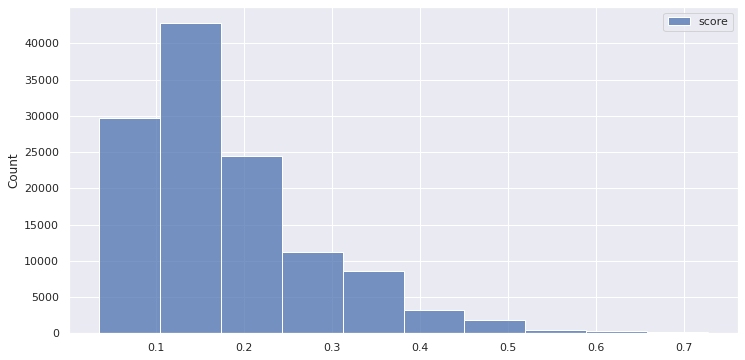

In [98]:
#conduct a count plot for 
ax = sns.histplot(data=pred_proba_pd,bins=10)

As we can see the distribution of the score is not showing a polarized shape on two end so it would be helpful to implement the optimal threshold to make binary classfication. However, as expected we can also see that the majority of SKUs in the active dataset have a sold flag probability below 0.3

In [99]:
#classify the binary decision based on the optimal threshold value
opt_decision = pd.DataFrame((pred_proba >= optimal_threshold).astype('int') ).rename(columns={0:'binary_decision'})

In [100]:
opt_decision

,binary_decision
0,1
1,1
2,1
3,1
4,1
...,...
122916,0
122917,0
122918,0
122919,0


In [103]:
# percent of active inventory predicted to sell within the next six months using the optimized threshold and binary classification random forest model
opt_decision['binary_decision'].sum()/len(opt_decision)

0.45741573856379303

## Conclusion

After building two models, Logistic Regression and Random Forest to predict whether SKUs in the Active inventory will be sold in the next six months, we have concluded that about 45% of SKUs in the active dataset will sell in the next six months. Sensitivity with threshold optimization for this model is: 0.70, and specificity with threshold optimization is 0.70.